In [36]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import argparse
import os

import regionmask

from line_profiler import LineProfiler
import pdb

In [28]:
!pip uninstall -y shapely


Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1


In [29]:
pip install shapely==1.5.13

Defaulting to user installation because normal site-packages is not writeable
  Using cached Shapely-1.5.13-py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
regionmask 0.9.0 requires shapely>=1.7, but you have shapely 1.5.13 which is incompatible.
geopandas 0.12.2 requires shapely>=1.7, but you have shapely 1.5.13 which is incompatible.
cartopy 0.21.1 requires shapely>=1.6.4, but you have shapely 1.5.13 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [105]:
import xarray as xr
import matplotlib.pyplot as plt

# List of region numbers to read in
region_numbers = [15,16]

# Empty list to store region-specific datasets
region_datasets = []

# Loop over each region
for region_number in region_numbers:
    # Define the file path for the region
    file_path = f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc"
    
    # Read the region-specific netCDF file into an xarray dataset
    region_dataset = xr.open_dataset(file_path, decode_times=False)
    region_dataset = region_dataset.isel(time=9)
    
    # Append the region-specific dataset to the list
    region_datasets.append(region_dataset)

# Concatenate the region-specific datasets along a new dimension
stacked_dataset = xr.concat(region_datasets, dim='region')

da_stacked =stacked_dataset.to_array()

# Plot the stacked dataset
da_stacked['primf'].plot()
plt.show()


KeyError: 'primf'

NameError: name 'region_dataset' is not defined

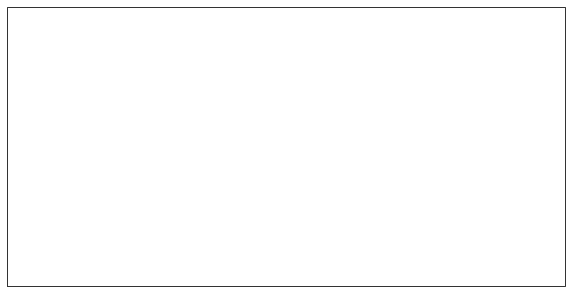

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create a plot with the PlateCarree projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data on the map
region_dataset['primf'].plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', cmap='Reds')

# Add coastlines
ax.coastlines()
ax.set_extent([-20, 60, -40, 40], crs=ccrs.PlateCarree())

# Set the title
plt.title('primf values for time=1')

# Show the plot
plt.show()


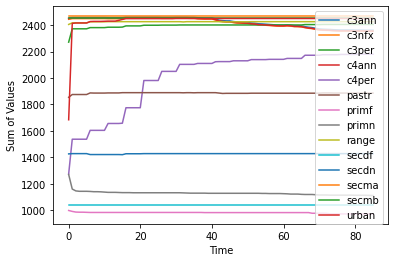

In [107]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the land use dataset

da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{15}.nc", decode_times=False)

variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
# Get the time values
time = da_landuse['time'].values

# Initialize the modified land use dataset
modified_landuse = da_landuse.copy()

# Loop over the data variables and check if the fraction is larger than 0
for variable in variable_names:
    fraction = da_landuse[variable]
    modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

# Calculate the sum of values for each variable
sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

fig, ax = plt.subplots()

# Loop over the data variables and plot the sum of values over time
for variable in variable_names:
    values = sum_over_values[variable].values.flatten()
    ax.plot(time, values, label=variable)

# Set the x-axis label and ticks
ax.set_xlabel('Time')

# Set the y-axis label
ax.set_ylabel('Sum of Values')
#ax.set_ylim(-10, 10)

# Add a legend
ax.legend()

# Display the plot
plt.show()


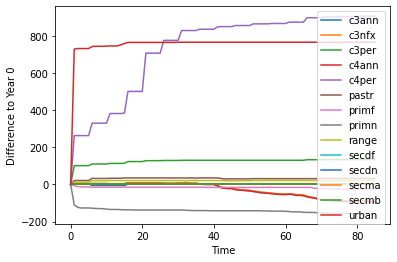

In [99]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the land use dataset

da_landuse = da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{15}.nc", decode_times=False)
variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
# Get the time values
time = da_landuse['time'].values

# Initialize the modified land use dataset
modified_landuse = da_landuse.copy()

# Loop over the data variables and check if the fraction is larger than 0
for variable in variable_names:
    fraction = da_landuse[variable]
    modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

# Calculate the sum of values for each variable
sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

# Calculate the difference compared to year 0
diff_to_year0 = sum_over_values - sum_over_values.sel(time=0)

fig, ax = plt.subplots()

# Loop over the data variables and plot the difference compared to year 0
for variable in variable_names:
    values = diff_to_year0[variable].values.flatten()
    ax.plot(time, values, label=variable)

# Set the x-axis label and ticks
ax.set_xlabel('Time')

# Set the y-axis label
ax.set_ylabel('Difference to Year 0')

# Add a legend
ax.legend()

# Display the plot
plt.show()


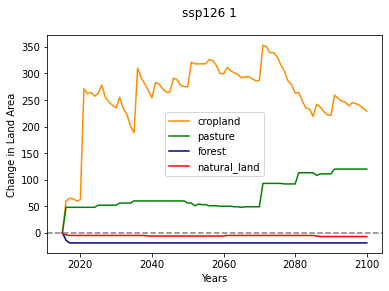

In [12]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np


category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}
years = np.arange(2015, 2015 + len(time))

# Load the land use dataset

da_landuse = da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{17}.nc", decode_times=False)
variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
# Get the time values
time = da_landuse['time'].values

# Initialize the modified land use dataset
modified_landuse = da_landuse.copy()

# Loop over the data variables and check if the fraction is larger than 0
for variable in variable_names:
    fraction = da_landuse[variable]
    modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

# Calculate the sum of values for each variable
sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

# Calculate the difference compared to year 0
#diff_to_year0 = sum_over_values - sum_over_values.isel(time=0)


# Create a new dataset for sum over categories
sum_over_categories = xr.Dataset()

# Sum the differences for cropland category
sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

# Sum the differences for pasture category
sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

# Sum the differences for forest category
sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

# Sum the differences for natural_land category
sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

difference = sum_over_categories - sum_over_categories.isel(time=0)


category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
}


# Create a figure and axes
fig, ax = plt.subplots()

# Loop over the categories
for category in category_mapping:
    # Get the difference values for the current category
    values = difference[category].values

    # Plot the difference values for the current category with the corresponding color
    ax.plot(years, values, label=category, color=category_colors[category])

# Add a horizontal line at y=0.0
ax.axhline(y=0.0, color='grey', linestyle='--')

# Set the x-axis label and ticks
ax.set_xlabel('Years')

# Set the y-axis label
ax.set_ylabel('Change in Land Area')

# Set the y-axis limits
#ax.set_ylim(-10, 10)

# Add a legend
ax.legend()
plt.suptitle("ssp126 "+  str(region_number))

# Display the plot
plt.show()

In [8]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Load the historical dataset and select the 1146th time point
da_historic = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc", decode_times=False)
da_historic = da_historic.isel(time=1146)

# Initialize a dataset to store the sums for the historical dataset
sum_over_categories_historic = xr.Dataset()

# Sum the fractions for each category in the historical dataset
for category, variables in category_mapping.items():
    sum_over_categories_historic[category] = sum([da_historic[var] for var in variables])

# Load the land use dataset for all regions
regions = range(1, 26)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for each category
    for category, variables in category_mapping.items():
        sum_over_categories[category] = sum([sum_over_values[var] for var in variables])

    # Calculate the difference compared to historical data
    difference = sum_over_categories - sum_over_categories_historic

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, ax = plt.subplots()

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category and reshape
        values = np.mean(difference[category].values, axis=(1, 2))

        # Plot the difference values for the current category with the corresponding color
        ax.plot(time, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('Change in Land Area compared to 1995')
    region_name = region_abbrevs[region_number - 1]  # Index into abbreviations list correctly

    # Set the title with region number
    ax.set_title(f'SSP126 Region {region_name}')

    # Add a legend
    ax.legend()

    # Save the figure to a file
    fig.savefig(f'region_{region_name}.png')

    # Close the figure to prevent overwriting
    plt.close(fig)


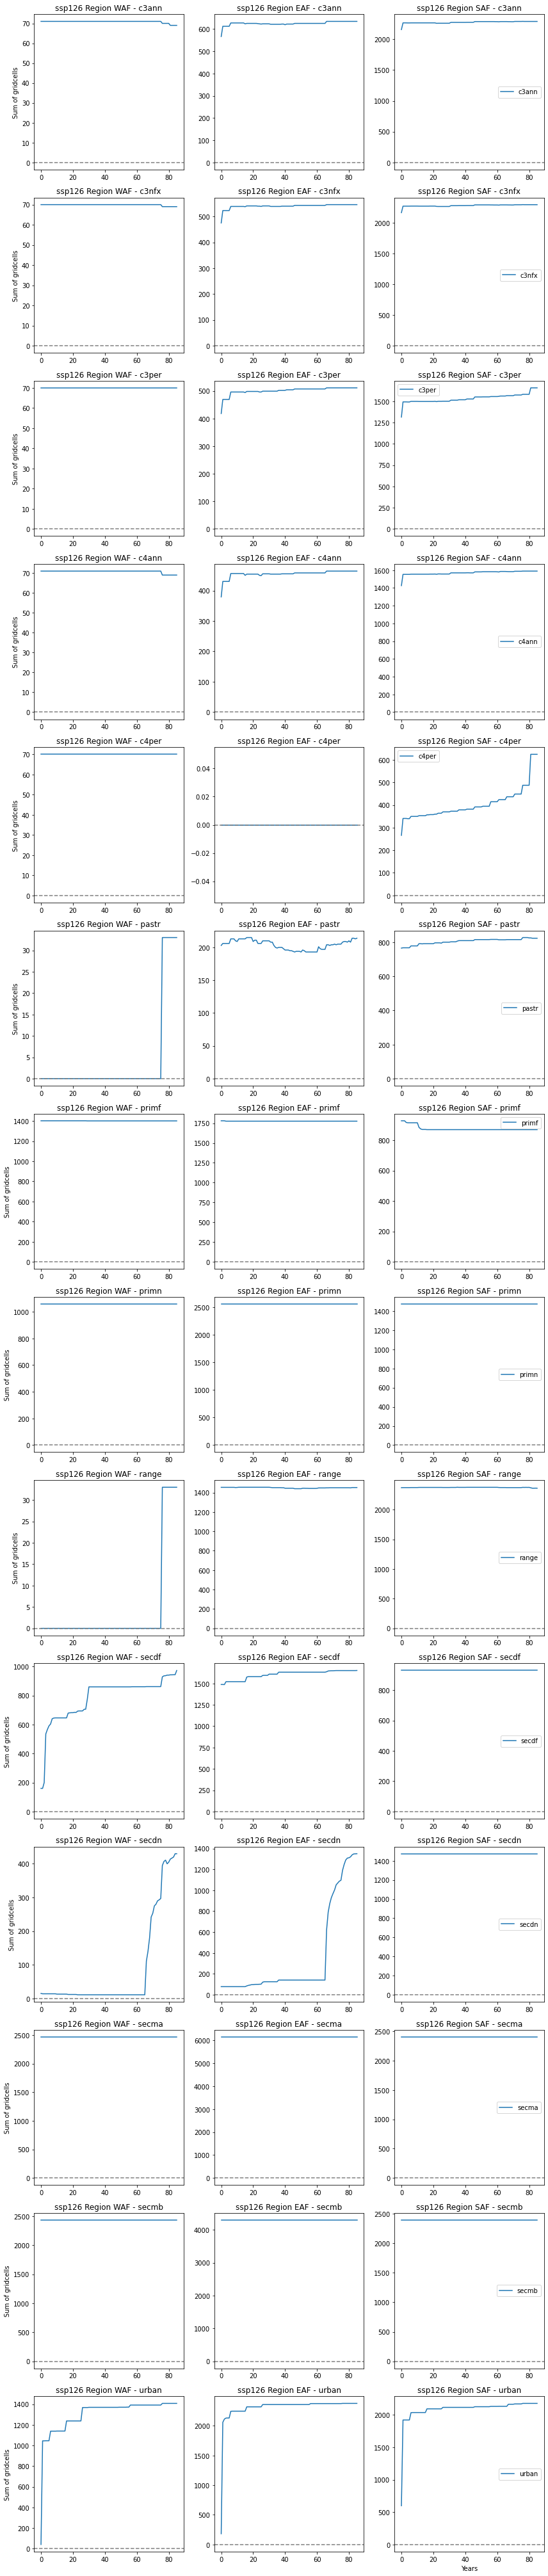

In [9]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['WAF', 'EAF', 'SAF']

# Load the land use dataset for the specified regions
regions = [region_abbrevs.index(region)+1 for region in region_abbrevs]
num_regions = len(regions)
variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
num_variables = len(variable_names)
fig, axes = plt.subplots(nrows=num_variables, ncols=num_regions, figsize=(4*num_regions, 4*num_variables))

for i, region_number in enumerate(regions):
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    # Get the time values
    time = da_landuse['time'].values
    
    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Loop over the variables
    for j, variable in enumerate(variable_names):
        # Get the difference values for the current variable
        values = sum_over_values[variable].values

        # Plot the difference values for the current variable in the corresponding subplot
        ax = axes[j, i]
        ax.plot(time, values, label=variable)

        # Set the y-axis label for the leftmost subplots
        if i == 0:
            ax.set_ylabel('Sum of gridcells')

        # Add a horizontal line at y=0.0
        ax.axhline(y=0.0, color='grey', linestyle='--')

        # Set the title with region number and variable name
        region_name = region_abbrevs[region_number-1]
        ax.set_title(f'ssp126 Region {region_name} - {variable}')

        # Add a legend to the last column subplots
        if i == num_regions - 1:
            ax.legend()

    # Set the x-axis label for the bottom subplots
    if i == num_regions - 1:
        axes[-1, i].set_xlabel('Years')

# Adjust the layout to display plots neatly
plt.tight_layout()

# Display the plots
plt.show()


In [48]:
da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical_region2.nc", decode_times=False)


In [49]:
test2 = da_landuse.isel(time=0)


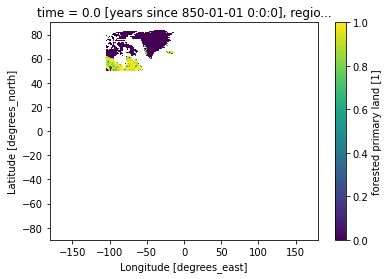

In [50]:
test2.primf.plot()

RuntimeError: NetCDF: HDF error

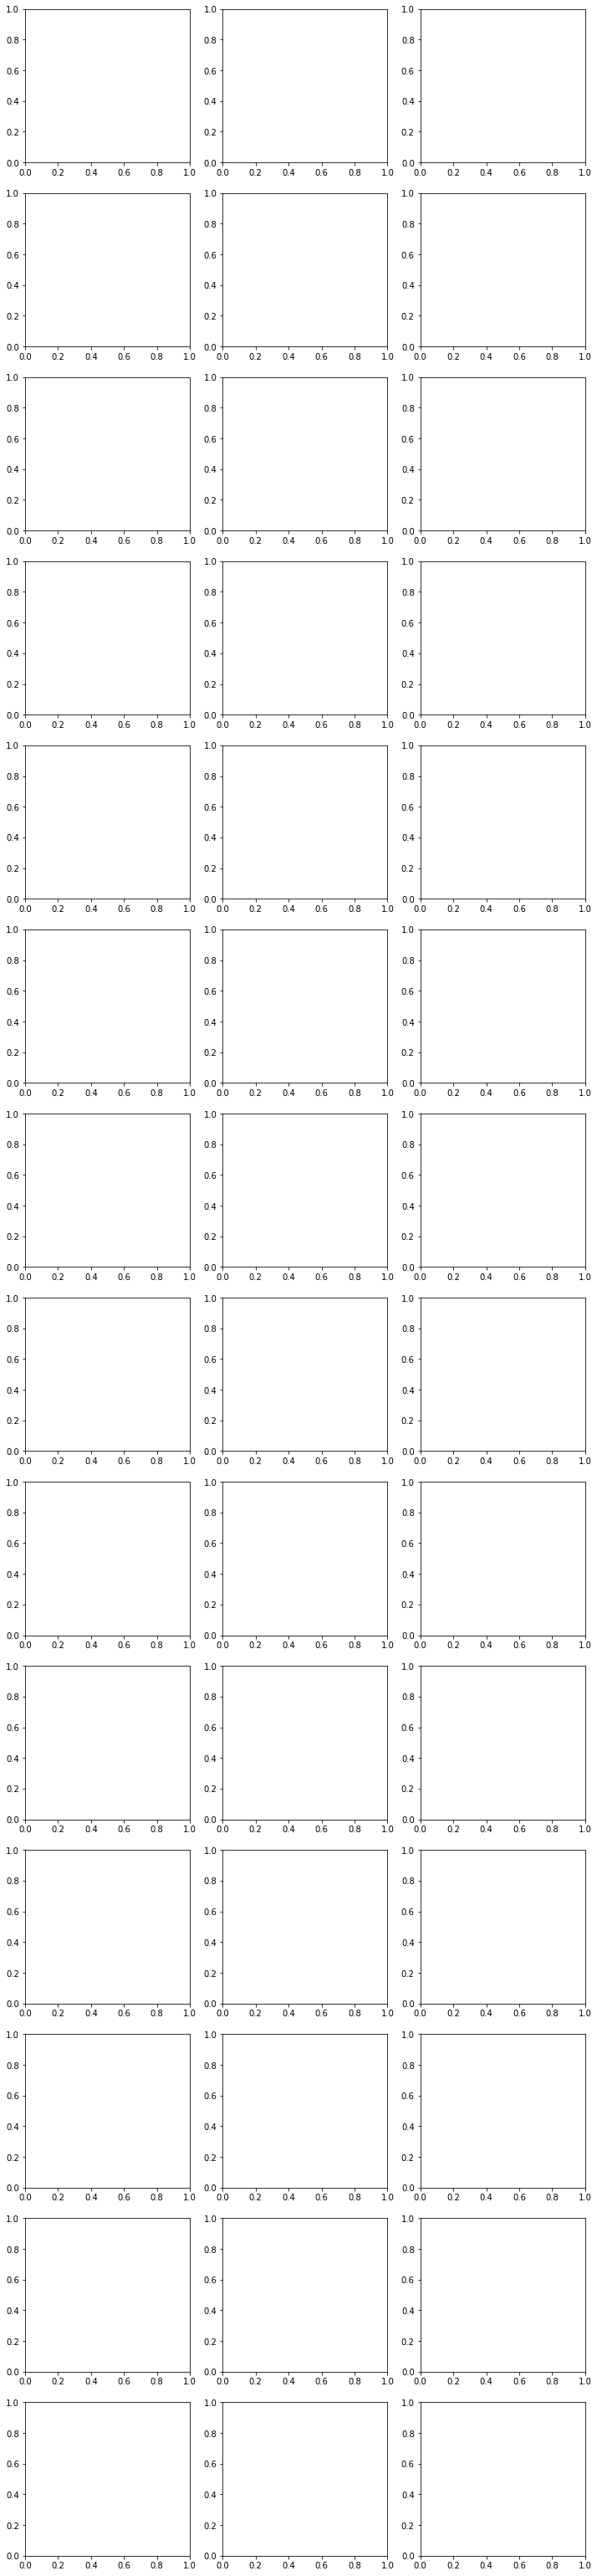

In [31]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['WAF', 'EAF', 'SAF']

# Load the land use dataset for the specified regions
regions = [region_abbrevs.index(region)+1 for region in region_abbrevs]
num_regions = len(regions)
variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
num_variables = len(variable_names)
fig, axes = plt.subplots(nrows=num_variables, ncols=num_regions, figsize=(4*num_regions, 4*num_variables))

for i, region_number in enumerate(regions):
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    # Get the time values
    time = da_landuse['time'].values
    
    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Loop over the variables
    for j, variable in enumerate(variable_names):
        # Get the difference values for the current variable
        values = sum_over_values[variable].values

        # Plot the difference values for the current variable in the corresponding subplot
        ax = axes[j, i]
        ax.plot(time, values, label=variable)

        # Set the y-axis label for the leftmost subplots
        if i == 0:
            ax.set_ylabel('Sum of gridcells')

        # Add a horizontal line at y=0.0
        ax.axhline(y=0.0, color='grey', linestyle='--')

        # Set the title with region number and variable name
        region_name = region_abbrevs[region_number-1]
        ax.set_title(f'ssp126 Region {region_name} - {variable}')

        # Add a legend to the last column subplots
        if i == num_regions - 1:
            ax.legend()

    # Set the x-axis label for the bottom subplots
    if i == num_regions - 1:
        axes[-1, i].set_xlabel('Years')

# Adjust the layout to display plots neatly
plt.tight_layout()

# Display the plots
plt.show()


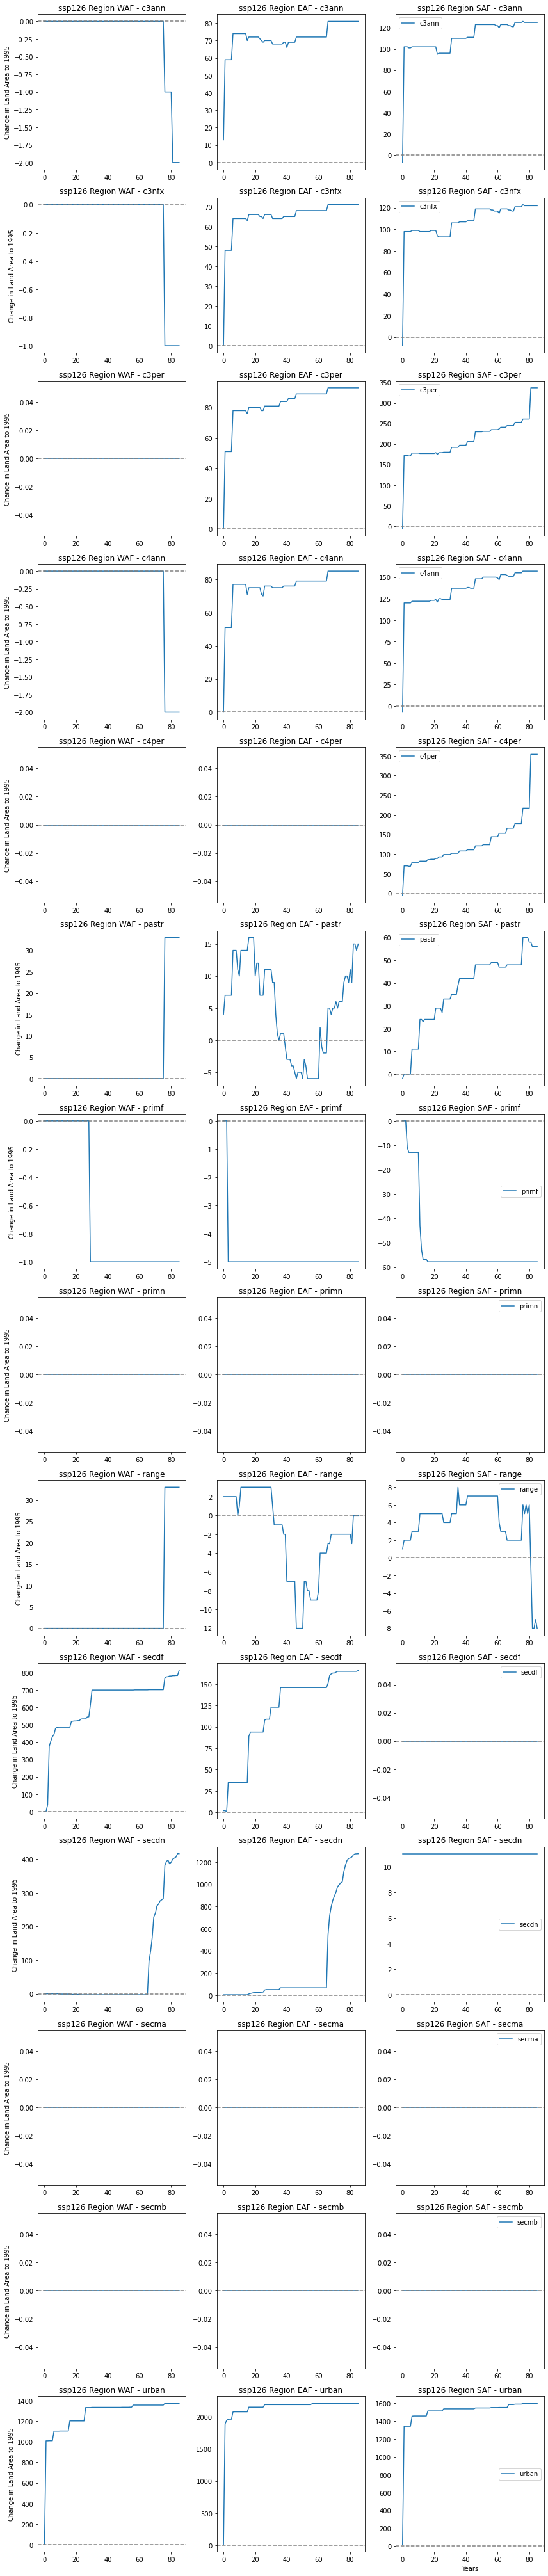

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['WAF', 'EAF', 'SAF']

# Load the land use dataset for the specified regions
regions = [region_abbrevs.index(region)+1 for region in region_abbrevs]
num_regions = len(regions)
num_variables = len(variable_names)
fig, axes = plt.subplots(nrows=num_variables, ncols=num_regions, figsize=(4*num_regions, 4*num_variables))

for i, region_number in enumerate(regions):
    

    da_historic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical_region{region_number}.nc", decode_times=False)
    da_historic = da_historic.isel(time=1146)

    # Initialize a dataset to store the sums for the historical dataset
    modified_landuse_historic = da_historic.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    variable_names = [var for var in modified_landuse_historic.data_vars.keys() if var != 'time_bnds']
    for variable in variable_names:
        fraction = da_historic[variable]
        modified_landuse_historic[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values_historic = modified_landuse_historic.sum(dim=[dim for dim in modified_landuse_historic.dims if dim != 'time'])

    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    # Get the time values
    time = da_landuse['time'].values
    
    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Loop over the variables
    for j, variable in enumerate(variable_names):
        # Get the difference values for the current variable
        values = sum_over_values[variable].values - sum_over_values_historic[variable].values

        # Plot the difference values for the current variable in the corresponding subplot
        ax = axes[j, i]
        ax.plot(time, values, label=variable)

        # Set the y-axis label for the leftmost subplots
        if i == 0:
            ax.set_ylabel('Change in Land Area to 1995')

        # Add a horizontal line at y=0.0
        ax.axhline(y=0.0, color='grey', linestyle='--')

        # Set the title with region number and variable name
        region_name = region_abbrevs[region_number-1]
        ax.set_title(f'ssp126 Region {region_name} - {variable}')

        # Add a legend to the last column subplots
        if i == num_regions - 1:
            ax.legend()

    # Set the x-axis label for the bottom subplots
    if i == num_regions - 1:
        axes[-1, i].set_xlabel('Years')

# Adjust the layout to display plots neatly
plt.tight_layout()

# Display the plots
plt.show()


In [24]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['WAF', 'EAF', 'SAF']

# Load the land use dataset for the specified regions
regions = [region_abbrevs.index(region)+1 for region in region_abbrevs]
num_regions = len(regions)
variable_names = []
fig, axes = plt.subplots(nrows=num_regions, figsize=(6, 4*num_regions))

for i, region_number in enumerate(regions):
    da_historic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical_region{region_number}.nc", decode_times=False)
    da_historic = da_historic.isel(time=1146)
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_historic.data_vars.keys() if var != 'time_bnds']
    time = da_landuse['time'].values

    for j, variable in enumerate(variable_names):
        values_historic = da_historic[variable].values
        values_65 = da_landuse[variable].sel(time=65).values
        values_85 = da_landuse[variable].sel(time=85).values

        difference_65 = values_65 - values_historic
        difference_85 = values_85 - values_historic

        # Plot the difference values for the current variable in the corresponding subplot
        ax = axes[i]
        ax.plot(time[:86], difference_65[:86], label=f'{variable} (65-Historic)')
        ax.plot(time[:86], difference_85[:86], label=f'{variable} (85-Historic)')

        # Set the y-axis label for the leftmost subplots
        if i == 0:
            ax.set_ylabel('Change in Land Area to 1995')

        # Add a horizontal line at y=0.0
        ax.axhline(y=0.0, color='grey', linestyle='--')

        # Set the title with region number
        region_name = region_abbrevs[region_number-1]
        ax.set_title(f'ssp126 Region {region_name}')

        # Add a legend to the last subplot
        if i == num_regions - 1:
            ax.legend()

    # Set the x-axis label for the bottom subplot
    if i == num_regions - 1:
        axes[i].set_xlabel('Years')

# Adjust the layout to display plots neatly
plt.tight_layout()

# Display the plots
plt.show()


/scratch/local/55222971/ipykernel_74259/3904428915.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/scratch/local/55222971/ipykernel_74259/3904428915.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 392x302898 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x864 with 3 Axes>

/scratch/local/55011206/ipykernel_82417/679049799.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


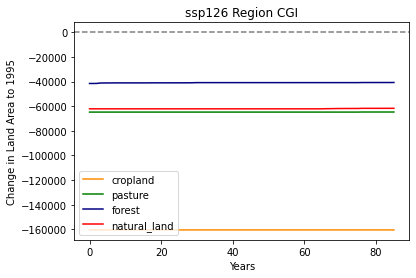

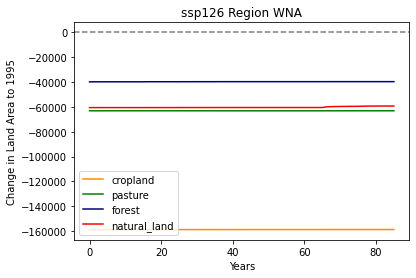

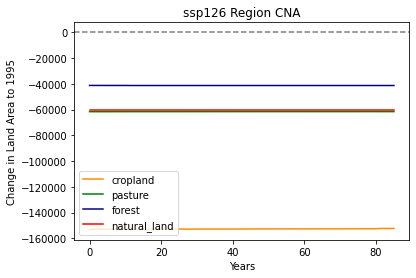

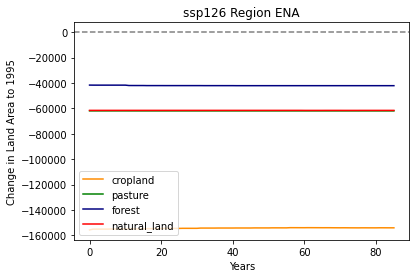

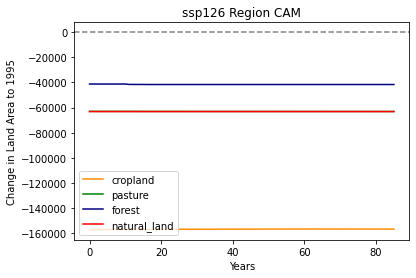

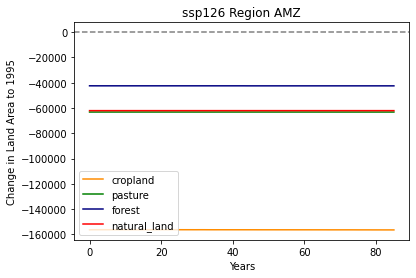

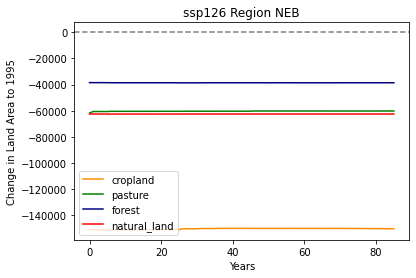

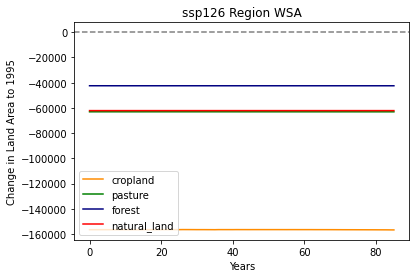

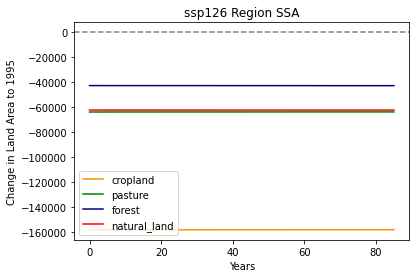

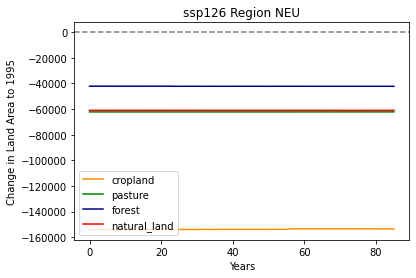

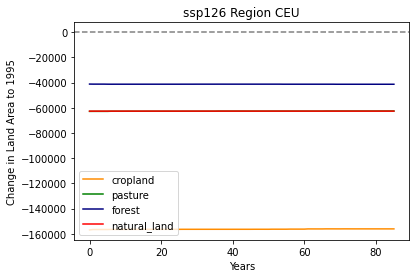

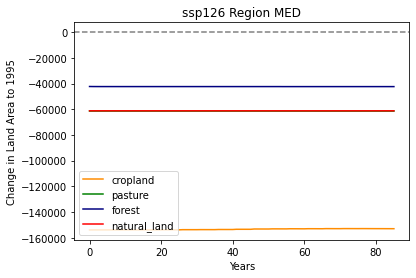

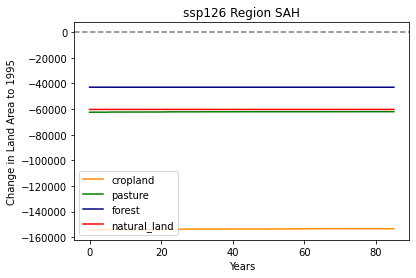

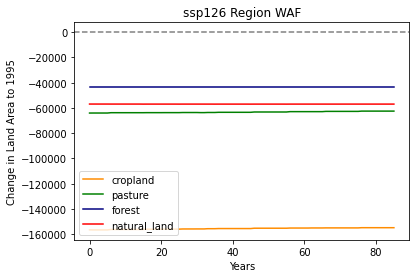

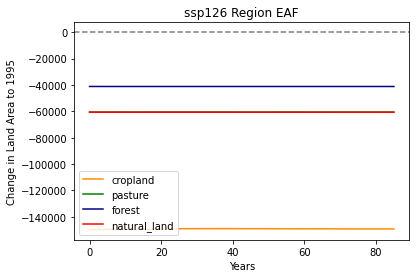

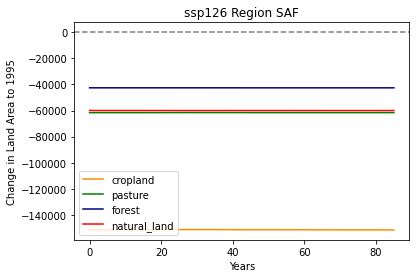

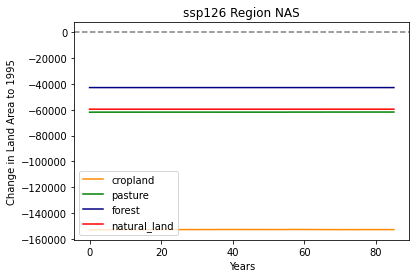

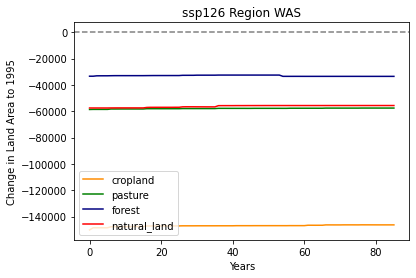

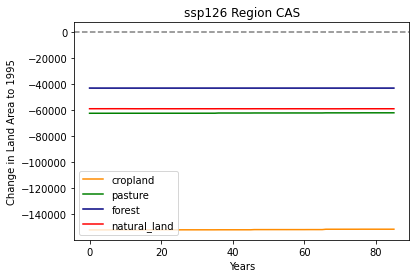

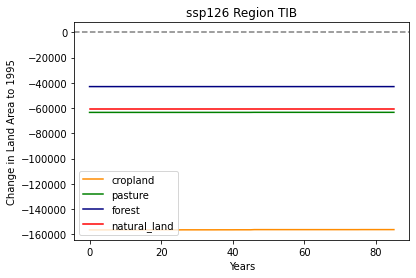

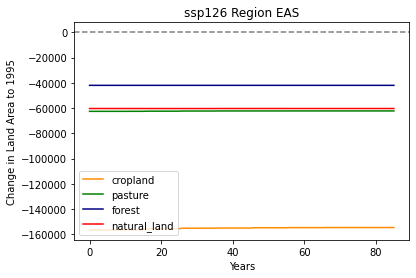

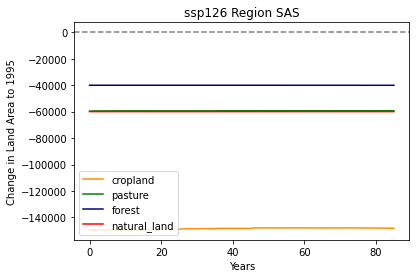

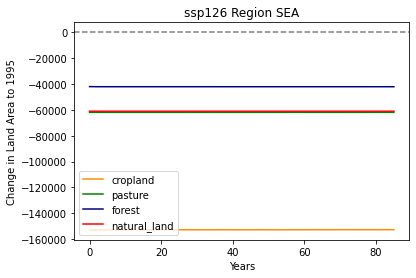

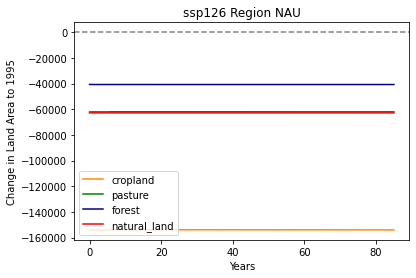

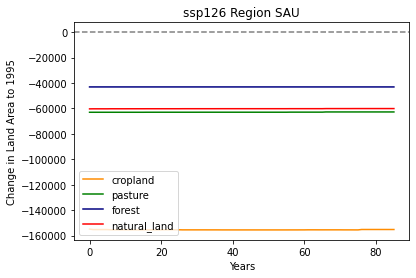

In [39]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = [ 'WAF', 'EAF', 'SAF']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

da_historic = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc", decode_times=False)
da_historic = da_historic.isel(time=1146)

# Initialize a dataset to store the sums for the historical dataset
modified_landuse_historic = da_historic.copy()

# Loop over the data variables and check if the fraction is larger than 0
variable_names = [var for var in modified_landuse_historic.data_vars.keys() if var != 'time_bnds']
for variable in variable_names:
    fraction = da_historic[variable]
    modified_landuse_historic[variable] = xr.where(fraction > 0, 1, 0)

# Calculate the sum of values for each variable
sum_over_values_historic = modified_landuse_historic.sum(dim=[dim for dim in modified_landuse_historic.dims if dim != 'time'])

sum_over_categories_historic = xr.Dataset()

# Sum the differences for cropland category
sum_over_categories_historic['cropland'] = sum_over_values_historic['c3ann'] + sum_over_values_historic['c3per'] + sum_over_values_historic['c4ann'] + sum_over_values_historic['c4per'] + sum_over_values_historic['c3nfx']

# Sum the differences for pasture category
sum_over_categories_historic['pasture'] = sum_over_values_historic['pastr'] + sum_over_values_historic['range']

# Sum the differences for forest category
sum_over_categories_historic['forest'] = sum_over_values_historic['primf'] + sum_over_values_historic['secdf']

# Sum the differences for natural_land category
sum_over_categories_historic['natural_land'] = sum_over_values_historic['primn'] + sum_over_values_historic['secdn']

# Load the land use dataset for all regions
regions = range(1, 26)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values
    
    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    # Calculate the difference compared to year 0
    difference = sum_over_categories - sum_over_categories_historic

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, ax = plt.subplots()

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        # Plot the difference values for the current category with the corresponding color
        ax.plot(time, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('Change in Land Area to 1995')
    region_name = region_abbrevs[region_number]
    # Set the title with region number
    ax.set_title(f'ssp126 Region {region_name}')

    # Add a legend
    ax.legend()

# Adjust the layout to display plots next to each other
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


/scratch/local/55011206/ipykernel_82417/1623669852.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


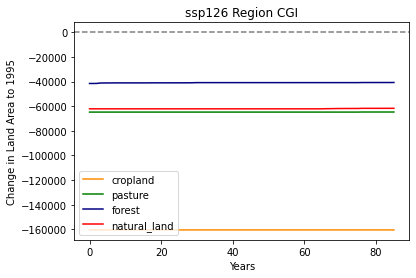

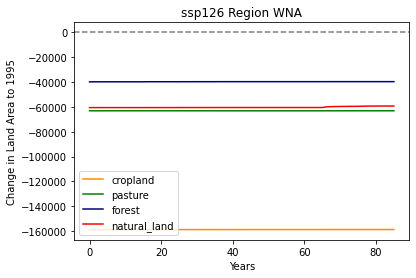

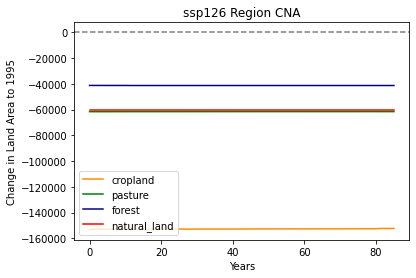

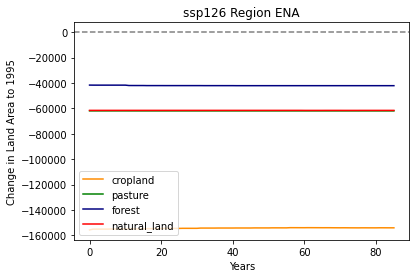

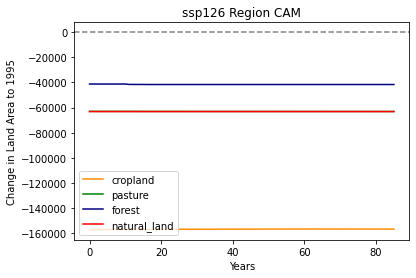

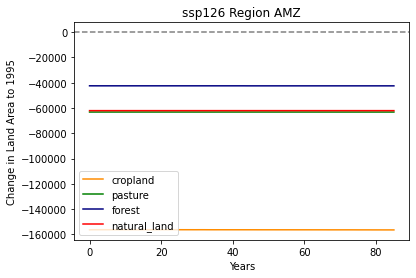

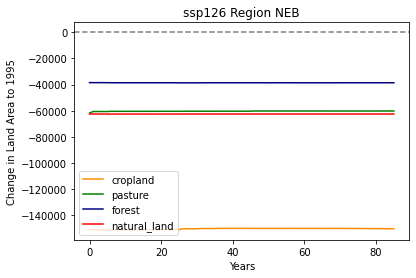

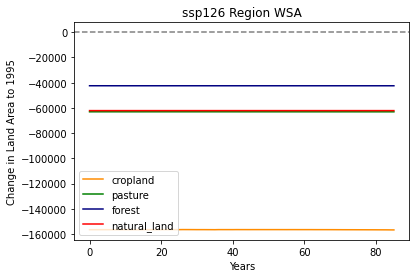

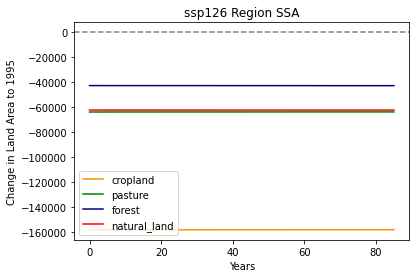

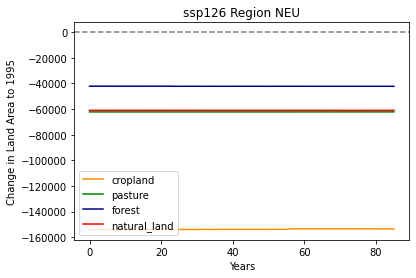

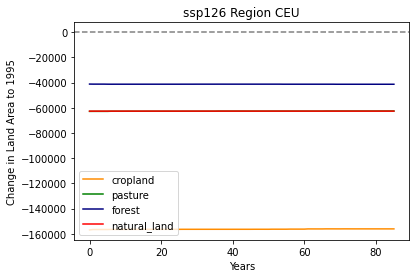

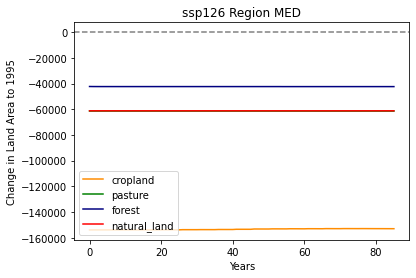

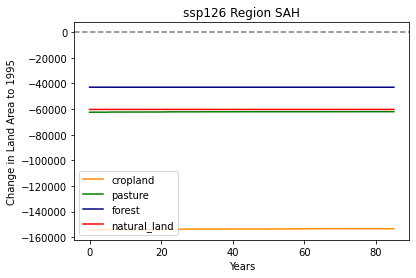

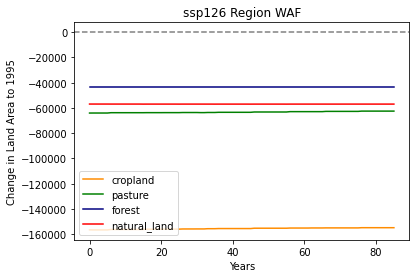

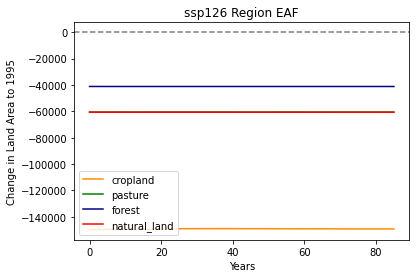

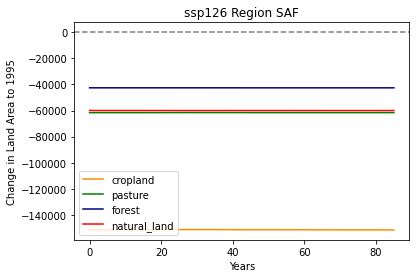

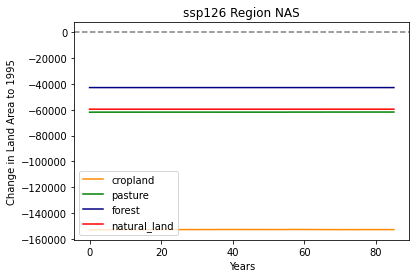

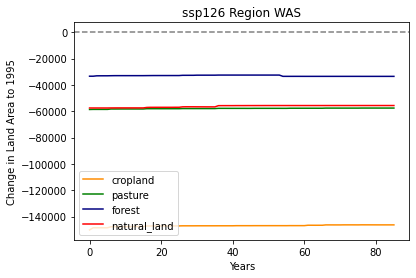

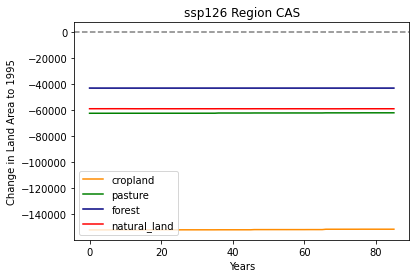

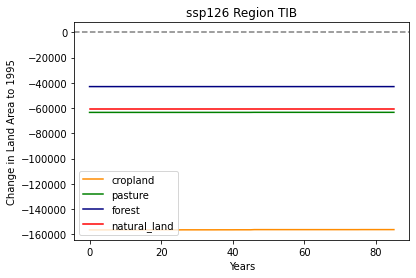

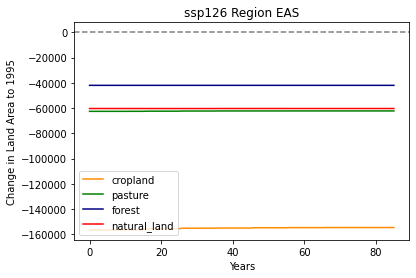

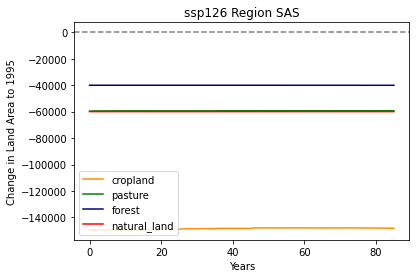

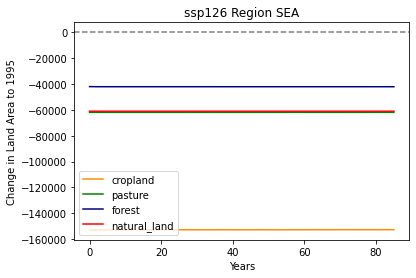

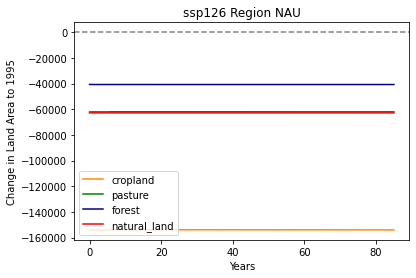

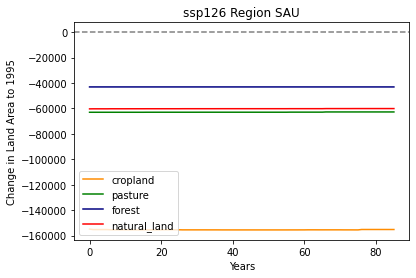

In [44]:
#Differnence to 1995

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

da_historic = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc", decode_times=False)
da_historic = da_historic.isel(time=1146)

# Initialize a dataset to store the sums for the historical dataset
modified_landuse_historic = da_historic.copy()

# Loop over the data variables and check if the fraction is larger than 0
for variable in variable_names:
    fraction = da_historic[variable]
    modified_landuse_historic[variable] = xr.where(fraction > 0, 1, 0)

# Calculate the sum of values for each variable
sum_over_values_historic = modified_landuse_historic.sum(dim=[dim for dim in modified_landuse_historic.dims if dim != 'time'])

sum_over_categories_historic = xr.Dataset()

# Sum the differences for cropland category
sum_over_categories_historic['cropland'] = sum_over_values_historic['c3ann'] + sum_over_values_historic['c3per'] + sum_over_values_historic['c4ann'] + sum_over_values_historic['c4per'] + sum_over_values_historic['c3nfx']

# Sum the differences for pasture category
sum_over_categories_historic['pasture'] = sum_over_values_historic['pastr'] + sum_over_values_historic['range']

# Sum the differences for forest category
sum_over_categories_historic['forest'] = sum_over_values_historic['primf'] + sum_over_values_historic['secdf']

# Sum the differences for natural_land category
sum_over_categories_historic['natural_land'] = sum_over_values_historic['primn'] + sum_over_values_historic['secdn']

# Load the land use dataset for all regions
regions = range(1, 26)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values
    

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    #difference = sum_over_categories - sum_over_categories.isel(time=0)
    
   

    # Calculate the difference compared to year 0
    difference = sum_over_categories - sum_over_categories_historic

    

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, ax = plt.subplots()

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        # Plot the difference values for the current category with the corresponding color
        ax.plot(time, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('Change in Land Area to 1995')
    region_name = region_abbrevs[region_number]
    # Set the title with region number
    ax.set_title(f'ssp126 Region {region_name}')

    # Add a legend
    ax.legend()

# Adjust the layout to display plots next to each other
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


In [43]:
sum_over_categories_historic[category]

<xarray.DataArray 'cropland' ()>
array(160791)
Coordinates:
    time     float64 1.146e+03

/scratch/local/54705986/ipykernel_104872/1078798493.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


IndexError: list index out of range

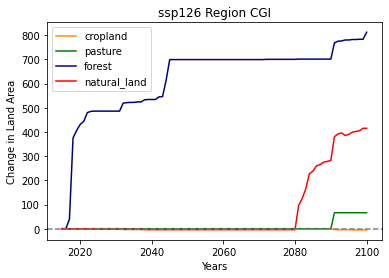

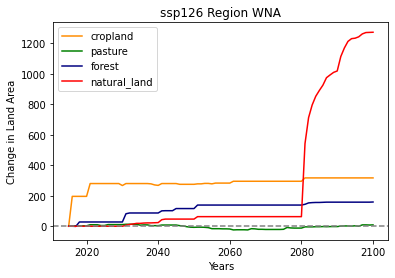

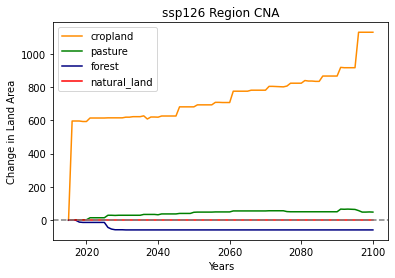

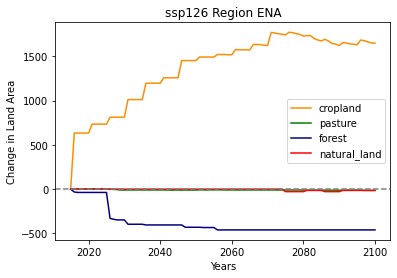

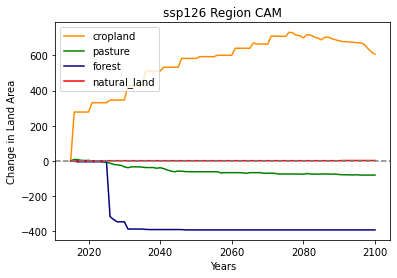

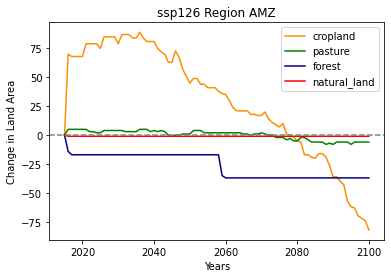

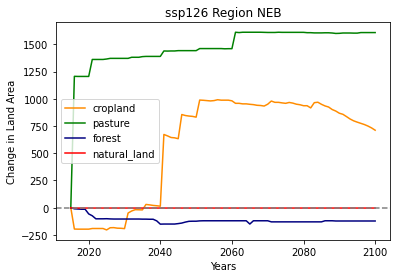

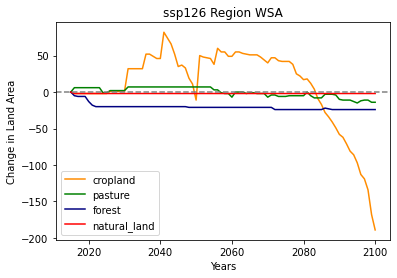

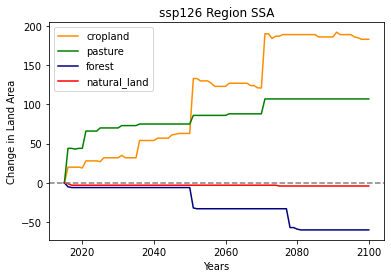

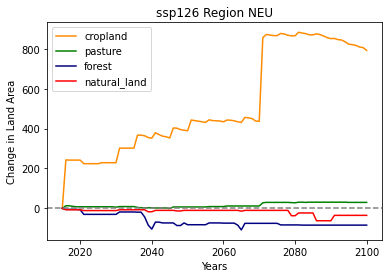

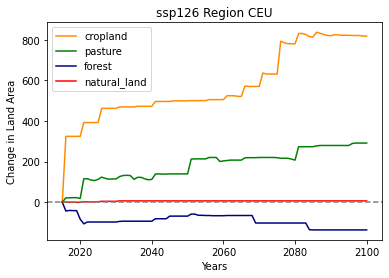

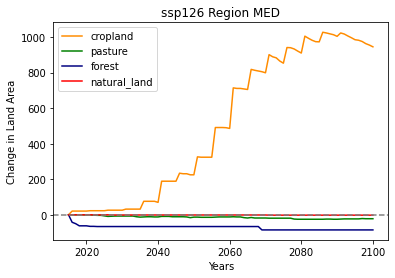

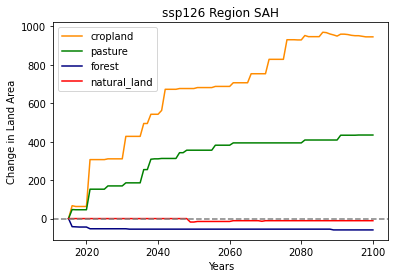

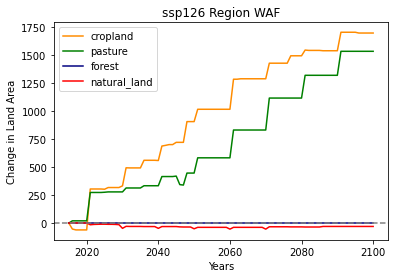

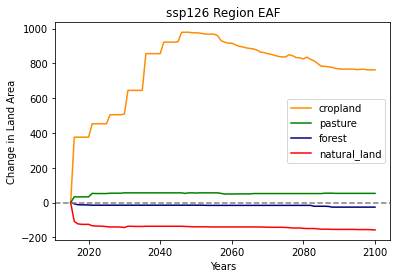

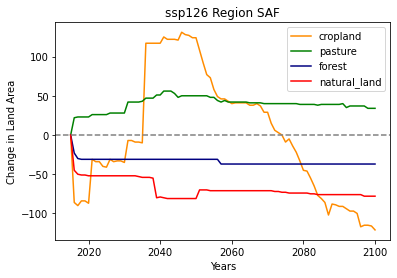

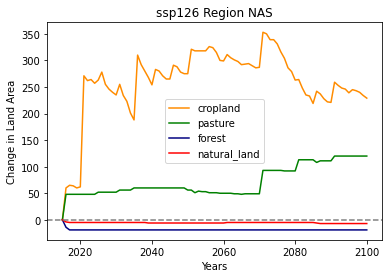

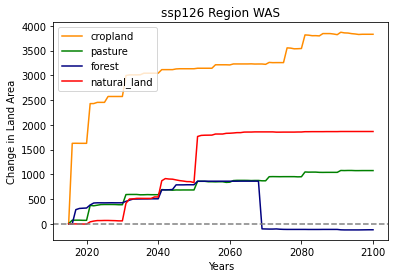

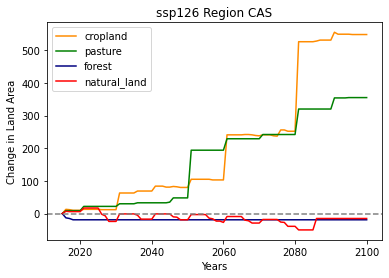

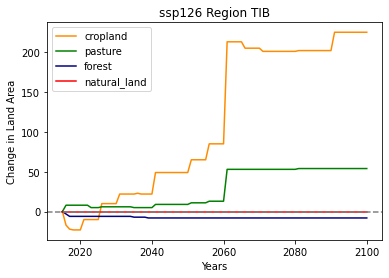

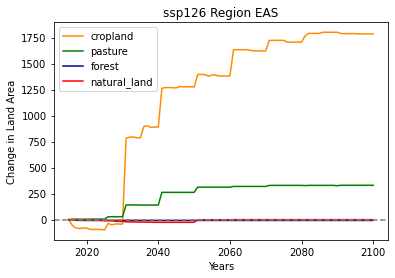

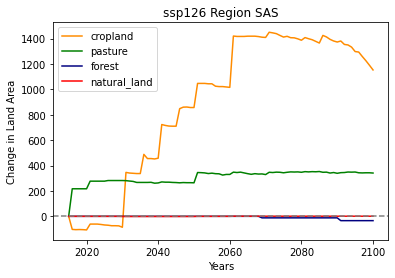

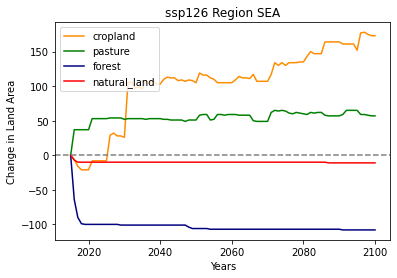

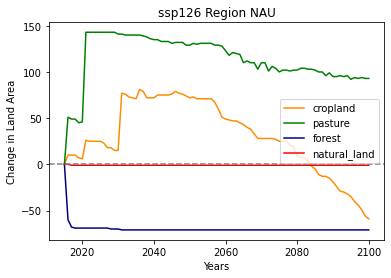

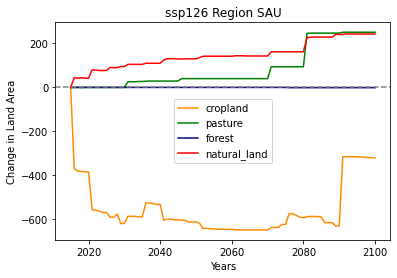

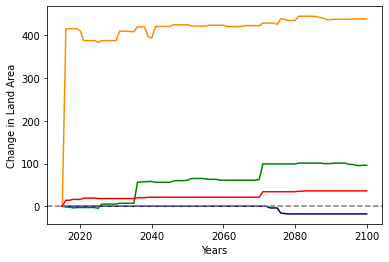

In [19]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Load the land use dataset for all regions
regions = range(1, 26)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values
    

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    difference = sum_over_categories - sum_over_categories.isel(time=0)

    # Calculate the difference compared to year 0
    difference = sum_over_categories - sum_over_categories.isel(time=0)

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, ax = plt.subplots()

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        # Plot the difference values for the current category with the corresponding color
        ax.plot(years, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('Change in Land Area')
    region_name = region_abbrevs[region_number]
    # Set the title with region number
    ax.set_title(f'ssp126 Region {region_name}')

    # Add a legend
    ax.legend()

# Adjust the layout to display plots next to each other
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


In [11]:
regions = range(1, len(region_abbrevs))


In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Load the land use dataset for all regions
regions = range(1, 26)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    difference = sum_over_categories - sum_over_categories.isel(time=0)

    # Calculate the difference compared to year 0
    difference = sum_over_categories - sum_over_categories.isel(time=0)

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, ax = plt.subplots()

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        #
        # Plot the difference values for the current category with the corresponding color
        ax.plot(years, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('Change in Land Area')
    region_name = region_abbrevs[region_number]
    # Set the title with region number
    ax.set_title(f'ssp126 Region {region_name}')

    # Add a legend
    ax.legend()

    # Count the number of grid cells with each category
    # Initialize a dictionary to store cell counts per category
    cell_count = {}

    # Loop over the categories
    for category in category_mapping:
        # Count the number of grid cells with the current category
        category_cells = np.count_nonzero(sum_over_categories[category].values)
        cell_count[category] = category_cells

    # Create a pie chart for the cell count per category
    fig, ax = plt.subplots()
    categories = list(cell_count.keys())
    cell_counts = list(cell_count.values())

    ax.pie(cell_counts, labels=categories, colors=[category_colors[category] for category in categories], autopct='%1.1f%%')
    ax.set_title(f'Cell Count per Category - Region {region_name}')

    # Display the pie chart
    plt.show()


KeyboardInterrupt: 

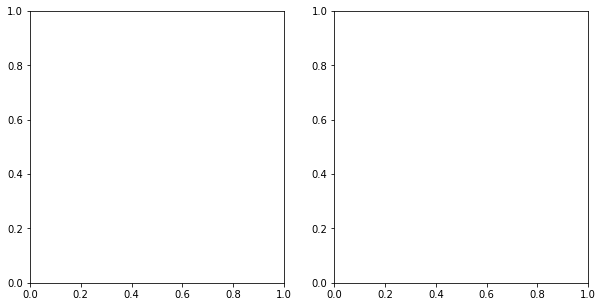

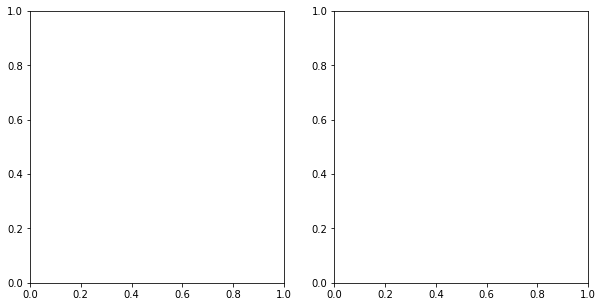

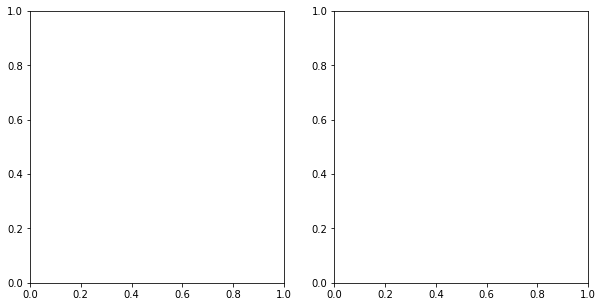

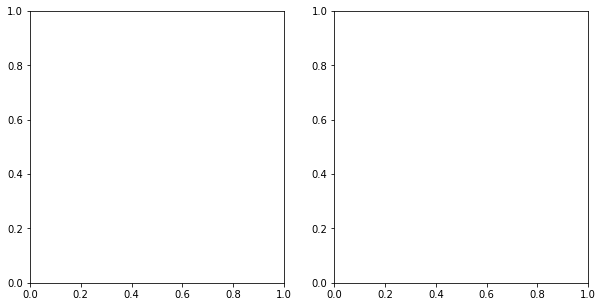

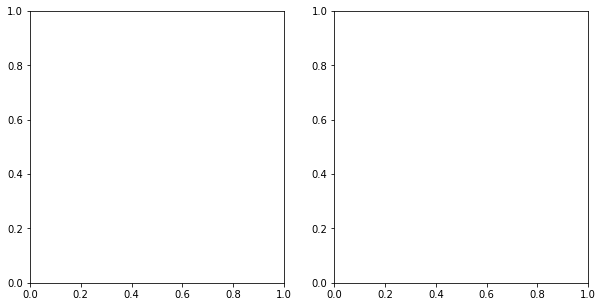

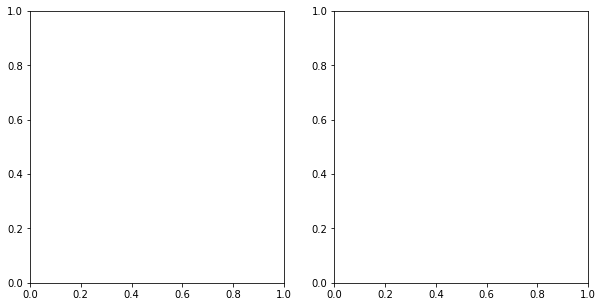

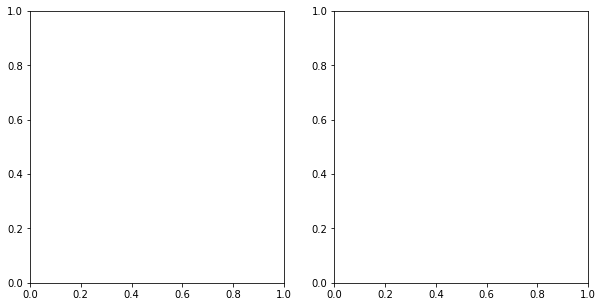

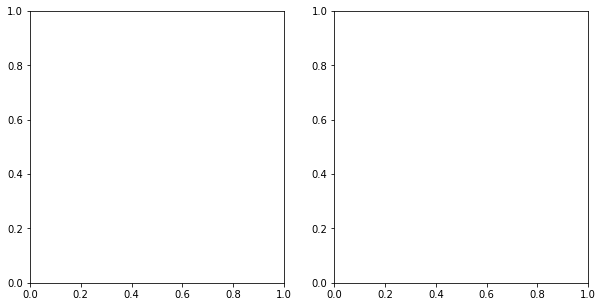

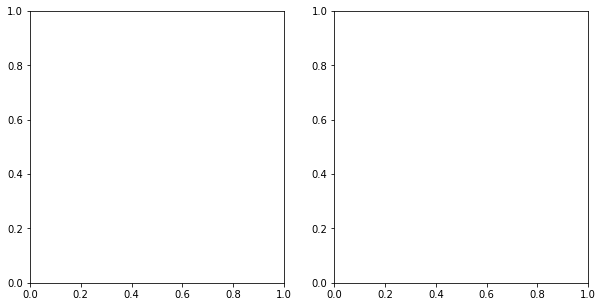

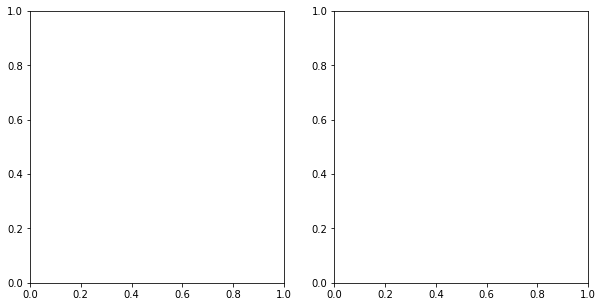

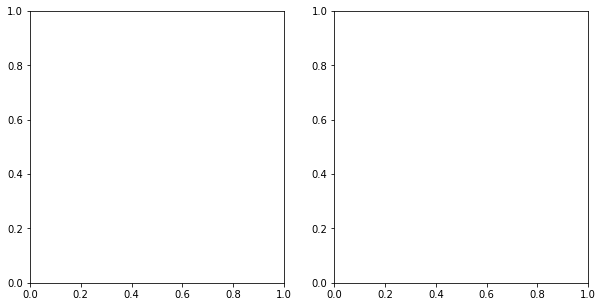

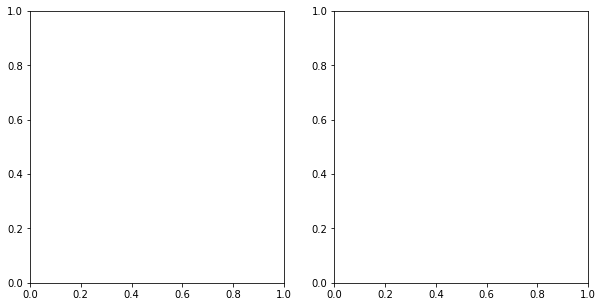

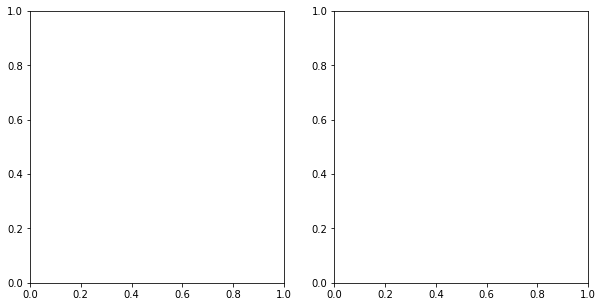

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Load the land use dataset for all regions
regions = range(1, 27)
for region_number in regions:
    # Load the land use dataset
    da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    difference = sum_over_categories - sum_over_categories.isel(time=0)

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    # Create a figure and axes for the current region
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    #


IndexError: list index out of range

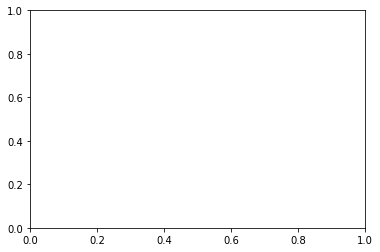

In [28]:
category_cells = np.count_nonzero(modified_landuse[category].values)

KeyError: 'cropland'

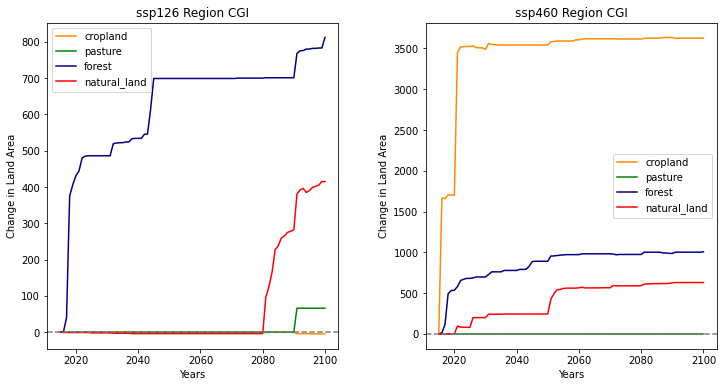

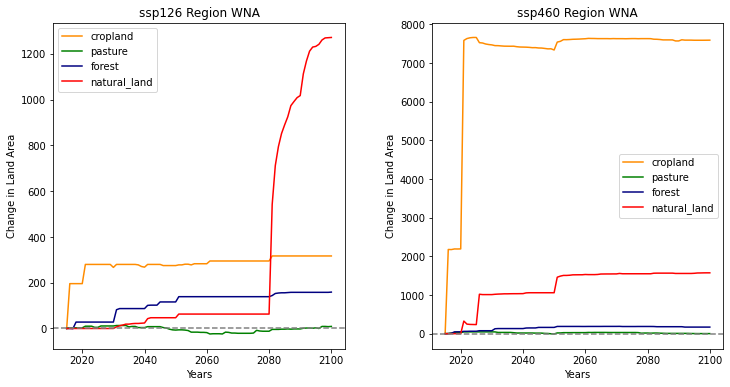

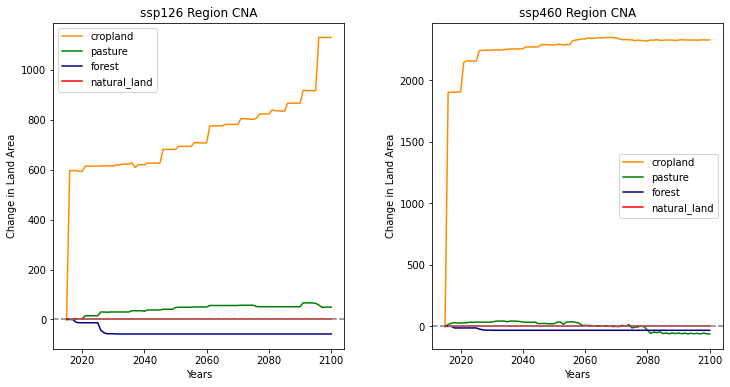

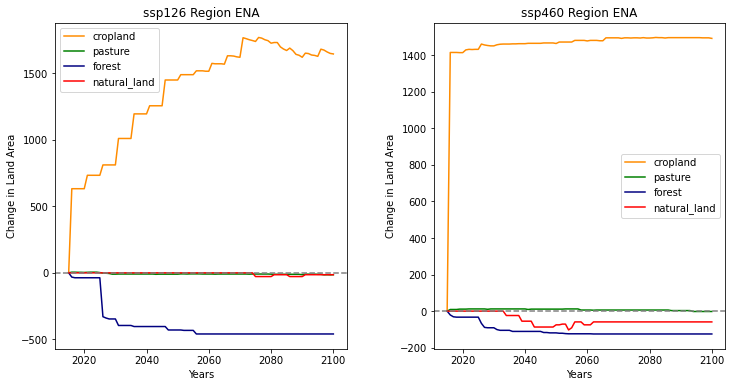

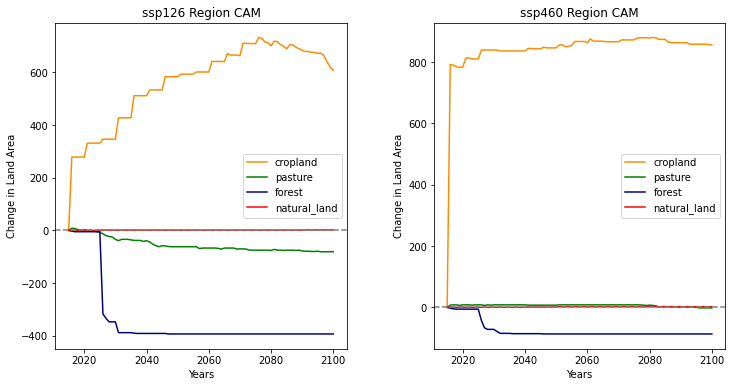

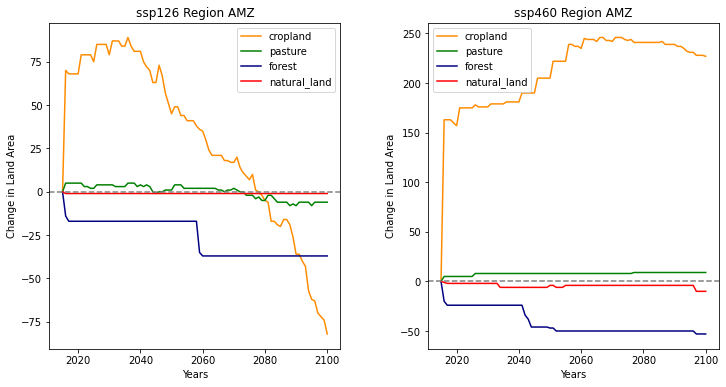

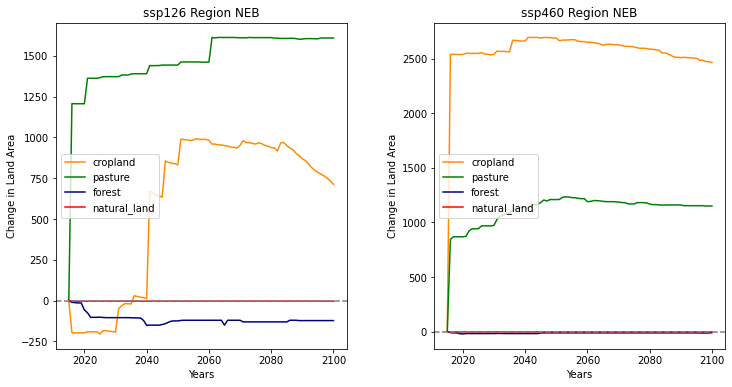

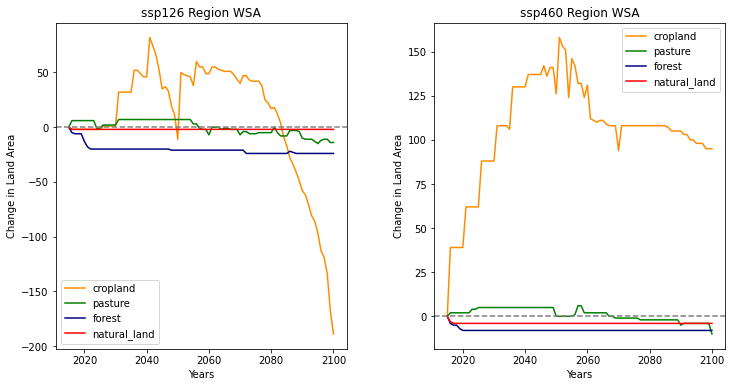

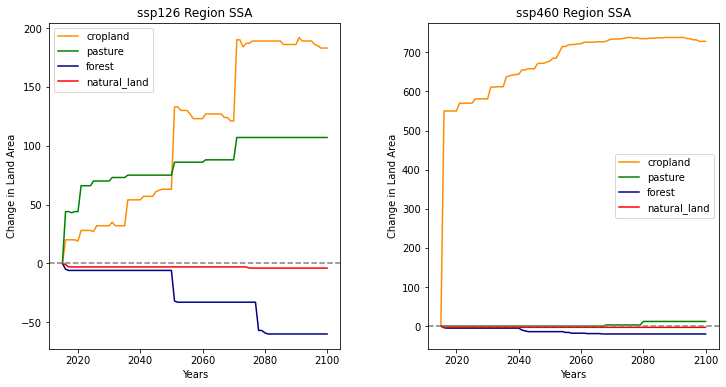

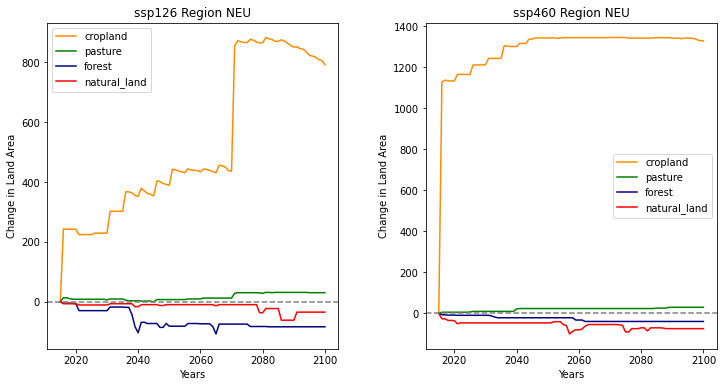

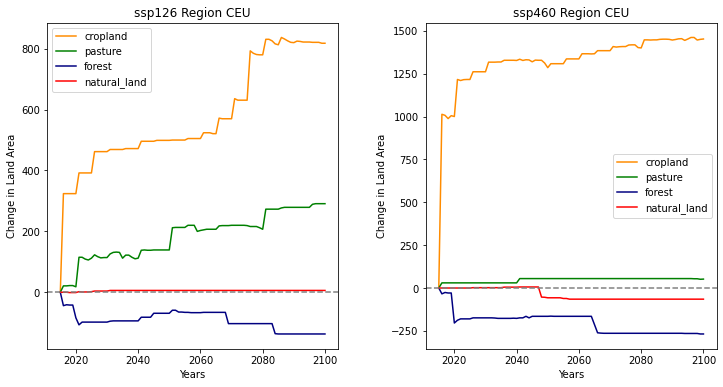

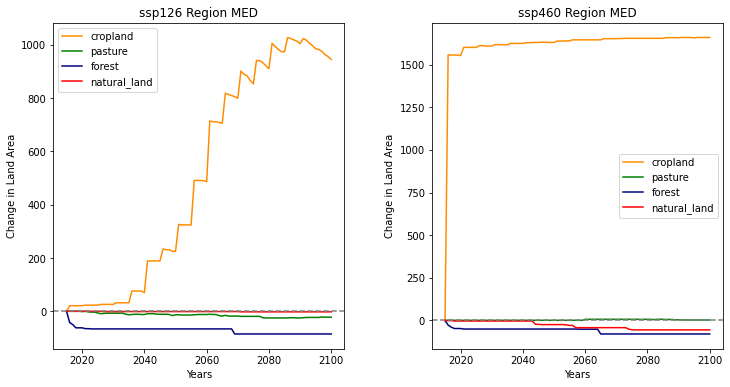

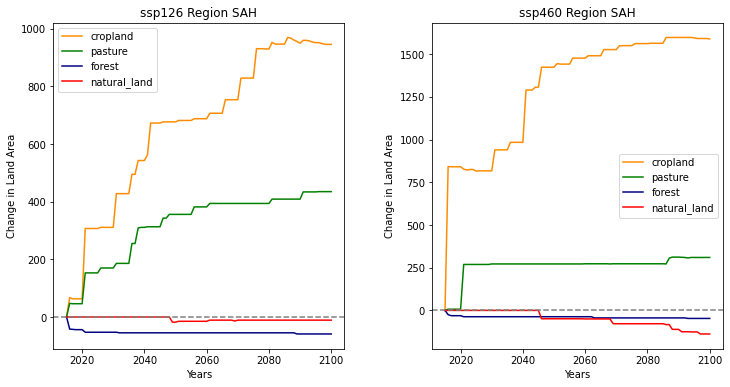

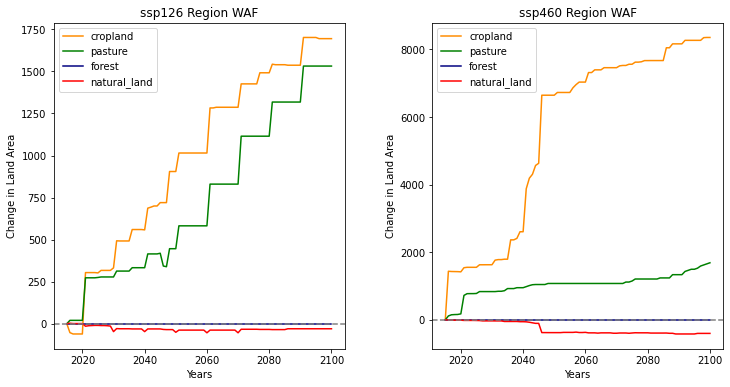

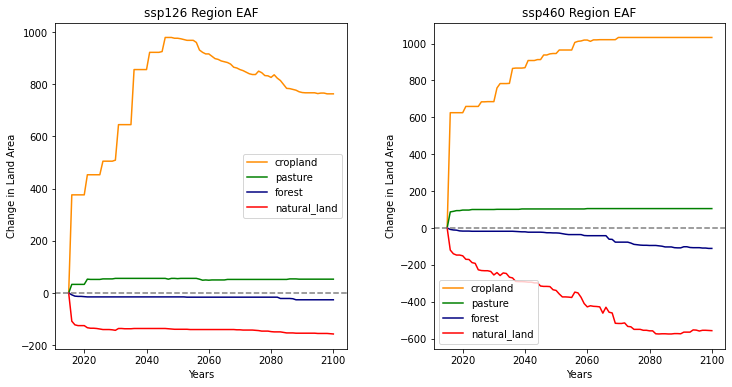

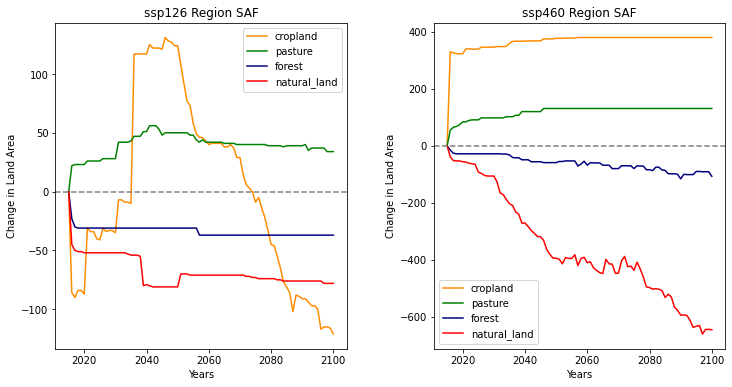

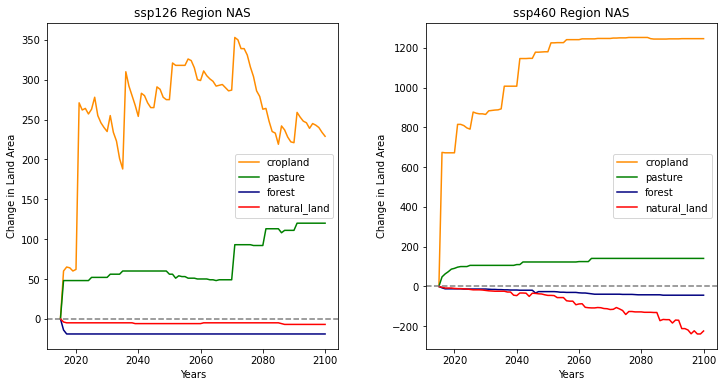

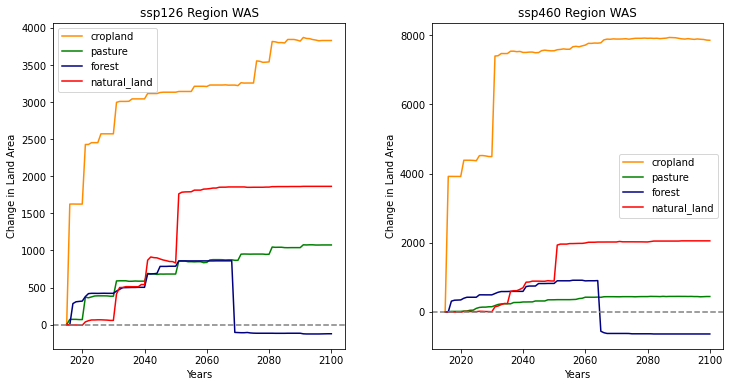

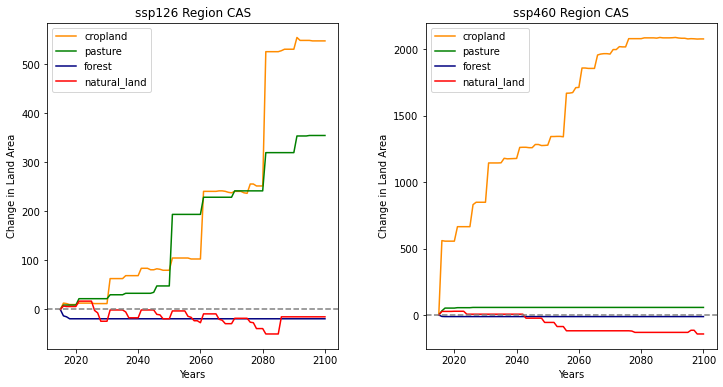

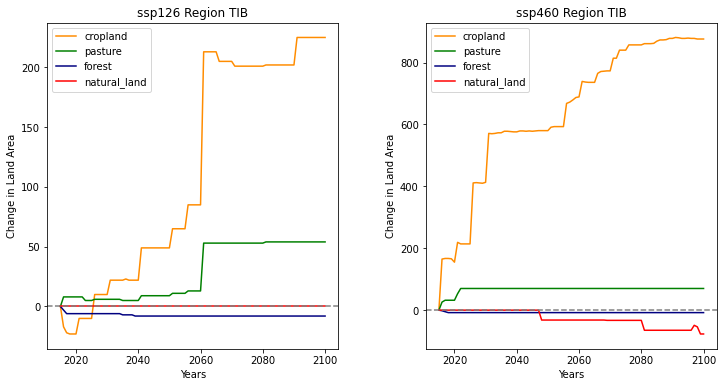

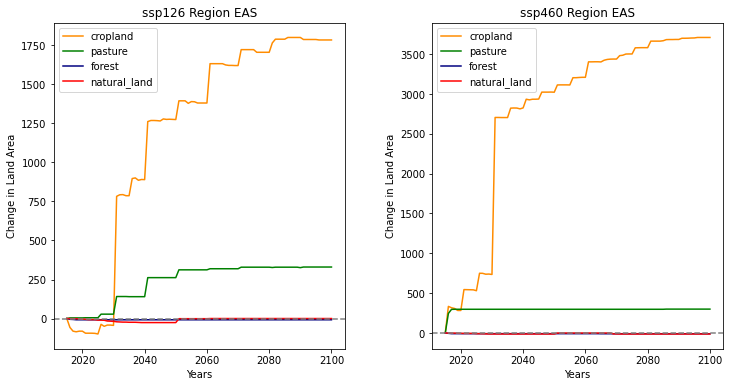

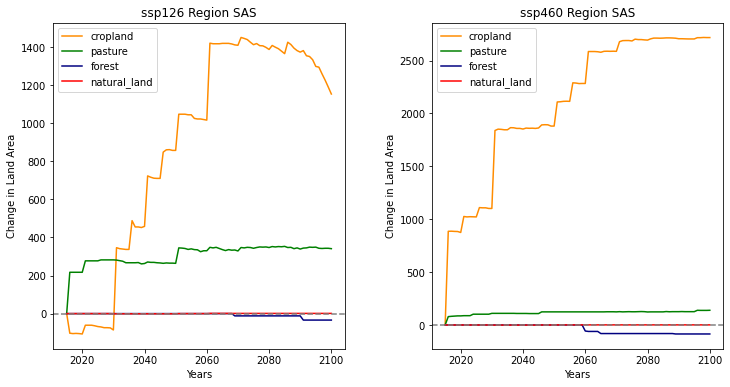

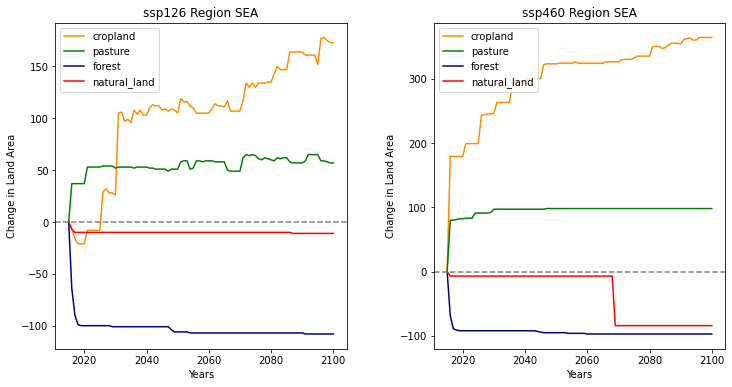

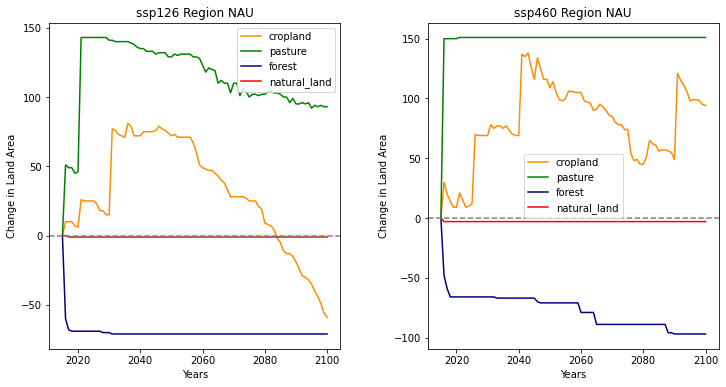

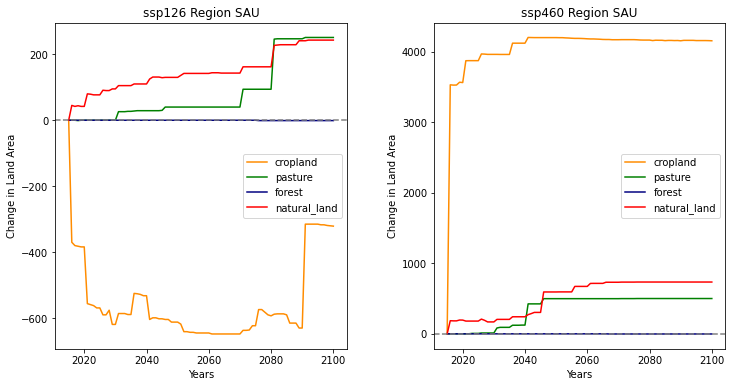

In [17]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
region_abbrevs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA',
                  'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS',
                  'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Load the land use dataset for all regions
regions = range(1, len(region_abbrevs))
# Load the land use dataset for all regions
for region_number in regions:
    # Load the land use dataset for ssp126
    da_landuse_ssp126 = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126_region{region_number}.nc", decode_times=False)
    variable_names_ssp126 = [var for var in da_landuse_ssp126.data_vars.keys() if var != 'time_bnds']

    # Load the land use dataset for ssp460
    da_landuse_ssp460 = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460_region{region_number}.nc", decode_times=False)
    variable_names_ssp460 = [var for var in da_landuse_ssp460.data_vars.keys() if var != 'time_bnds']

    # Get the time values for ssp126
    time_ssp126 = da_landuse_ssp126['time'].values

    # Get the time values for ssp460
    time_ssp460 = da_landuse_ssp460['time'].values
    years = np.arange(2015, 2015 + len(time_ssp460))

    # Initialize the modified land use datasets
    modified_landuse_ssp126 = da_landuse_ssp126.copy()
    modified_landuse_ssp460 = da_landuse_ssp460.copy()

    # Loop over the data variables and check if the fraction is larger than 0 for ssp126
    for variable in variable_names_ssp126:
        fraction = da_landuse_ssp126[variable]
        modified_landuse_ssp126[variable] = xr.where(fraction > 0, 1, 0)

    # Loop over the data variables and check if the fraction is larger than 0 for ssp460
    for variable in variable_names_ssp460:
        fraction = da_landuse_ssp460[variable]
        modified_landuse_ssp460[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable for ssp126
    sum_over_values_ssp126 = modified_landuse_ssp126.sum(dim=[dim for dim in modified_landuse_ssp126.dims if dim != 'time'])

    # Calculate the sum of values for each variable for ssp460
    sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

    sum_over_categories_ssp126 = xr.Dataset()
    sum_over_categories_ssp460 = xr.Dataset()

    # Sum the differences for cropland category for ssp126
    sum_over_categories_ssp126['cropland'] = sum_over_values_ssp126['c3ann'] + sum_over_values_ssp126['c3per'] + sum_over_values_ssp126['c4ann'] + sum_over_values_ssp126['c4per'] + sum_over_values_ssp126['c3nfx']

    # Sum the differences for pasture category for ssp126
    sum_over_categories_ssp126['pasture'] = sum_over_values_ssp126['pastr'] + sum_over_values_ssp126['range']

    # Sum the differences for forest category for ssp126
    sum_over_categories_ssp126['forest'] = sum_over_values_ssp126['primf'] + sum_over_values_ssp126['secdf']

    sum_over_categories_ssp126['natural_land'] = sum_over_values_ssp126['primn'] + sum_over_values_ssp126['secdn']

    sum_over_categories_ssp460['cropland'] = sum_over_values_ssp460['c3ann'] + sum_over_values_ssp460['c3per'] + sum_over_values_ssp460['c4ann'] + sum_over_values_ssp460['c4per'] + sum_over_values_ssp460['c3nfx']

    sum_over_categories_ssp460['pasture'] = sum_over_values_ssp460['pastr'] + sum_over_values_ssp460['range']

    sum_over_categories_ssp460['forest'] = sum_over_values_ssp460['primf'] + sum_over_values_ssp460['secdf']

    sum_over_categories_ssp460['natural_land'] = sum_over_values_ssp460['primn'] + sum_over_values_ssp460['secdn']
    
    difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_ssp126.isel(time=0)
    difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_ssp460.isel(time=0)
    
    category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
    }


    # Create a figure and axes for the current region
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for ssp126
    ax_ssp126 = axes[0]
    for category in category_mapping:
        values_ssp126 = difference_ssp126[category].values
        ax_ssp126.plot(years, values_ssp126, label=category, color=category_colors[category])
    ax_ssp126.axhline(y=0.0, color='grey', linestyle='--')
    ax_ssp126.set_xlabel('Years')
    ax_ssp126.set_ylabel('Change in Land Area')
    region_name = region_abbrevs[region_number]
    ax_ssp126.set_title(f'ssp126 Region {region_name}')
    ax_ssp126.legend()

    # Plot for ssp460
    ax_ssp460 = axes[1]
    for category in category_mapping:
        values_ssp460 = difference_ssp460[category].values
        ax_ssp460.plot(years, values_ssp460, label=category, color=category_colors[category])
    ax_ssp460.axhline(y=0.0, color='grey', linestyle='--')
    ax_ssp460.set_xlabel('Years')
    ax_ssp460.set_ylabel('Change in Land Area')
    ax_ssp460.set_title(f'ssp460 Region {region_name}')
    ax_ssp460.legend()

    # Adjust the layout to display plots next to each other
    plt.subplots_adjust(wspace=0.3)

    # Display the plots
    plt.show()




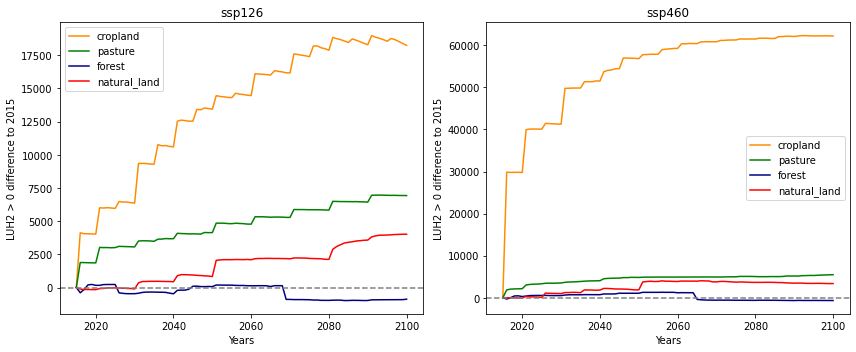

In [68]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

scenarios = ["ssp126", "ssp460"]
years = np.arange(2015, 2015 + len(time))
# Create a figure with two subplots

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(12, 5))

for i, scenario in enumerate(scenarios):
    # Load the land use dataset
    ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + scenario + ".nc"
    da_landuse = xr.open_dataset(ncfname, decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Create a new dataset for sum over categories
    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']
    

    difference = sum_over_categories - sum_over_categories.isel(time=0)

    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    ax = axes[i]  # Select the current subplot

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        # Plot the difference values for the current category with the corresponding color
        ax.plot(years, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('LUH2 > 0 difference to 2015')

    # Set the title for the subplot
    ax.set_title(scenario)

    # Add a legend
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


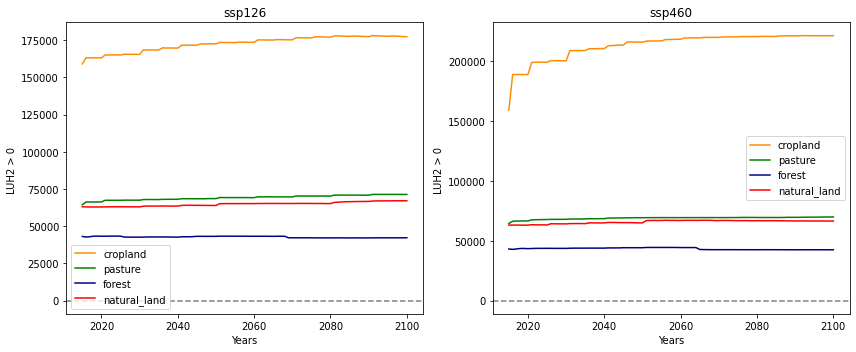

In [69]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

scenarios = ["ssp126", "ssp460"]
years = np.arange(2015, 2015 + len(time))
# Create a figure with two subplots

category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(12, 5))

for i, scenario in enumerate(scenarios):
    # Load the land use dataset
    ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + scenario + ".nc"
    da_landuse = xr.open_dataset(ncfname, decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Create a new dataset for sum over categories
    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']
    

    difference = sum_over_categories 
    category_colors = {
        'cropland': '#FF8C00',
        'pasture': 'green',
        'forest': '#000080',
        'natural_land': 'red'
    }

    ax = axes[i]  # Select the current subplot

    # Loop over the categories
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].values

        # Plot the difference values for the current category with the corresponding color
        ax.plot(years, values, label=category, color=category_colors[category])

    # Add a horizontal line at y=0.0
    ax.axhline(y=0.0, color='grey', linestyle='--')

    # Set the x-axis label and ticks
    ax.set_xlabel('Years')

    # Set the y-axis label
    ax.set_ylabel('LUH2 > 0 ')

    # Set the title for the subplot
    ax.set_title(scenario)

    # Add a legend
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


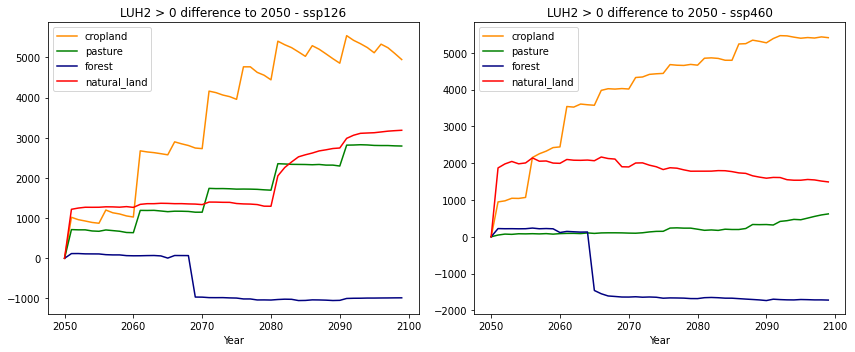

In [63]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

scenarios = ["ssp126", "ssp460"]
years = np.arange(2050, 2100)  # Years range from 2050 to 2100

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(12, 5))

# Define the category mapping for assigning colors
category_mapping = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
}

for i, scenario in enumerate(scenarios):
    # Load the land use dataset
    ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + scenario + ".nc"
    da_landuse = xr.open_dataset(ncfname, decode_times=False)
    variable_names = [var for var in da_landuse.data_vars.keys() if var != 'time_bnds']
    # Get the time values
    time = da_landuse['time'].values

    # Initialize the modified land use dataset
    modified_landuse = da_landuse.copy()

    # Loop over the data variables and check if the fraction is larger than 0
    for variable in variable_names:
        fraction = da_landuse[variable]
        modified_landuse[variable] = xr.where(fraction > 0, 1, 0)

    # Calculate the sum of values for each variable
    sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

    # Create a new dataset for sum over categories
    sum_over_categories = xr.Dataset()

    # Sum the differences for cropland category
    sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

    # Sum the differences for pasture category
    sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

    # Sum the differences for forest category
    sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

    # Sum the differences for natural_land category
    sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

    difference = sum_over_categories - sum_over_categories.isel(time=35)

    ax = axes[i]  # Select the current subplot

    # Loop over the categories and plot differences
    for category in category_mapping:
        # Get the difference values for the current category
        values = difference[category].isel(time=slice(35, 85))

        # Plot the difference values for the current category with the corresponding color
        ax.plot(years, values, label=category, color=category_mapping[category])

    # Set the x-axis label and title for the current subplot
    ax.set_xlabel('Year')
    ax.set_title('LUH2 > 0 difference to 2050 - ' + scenario)

    # Add a legend for the current subplot
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


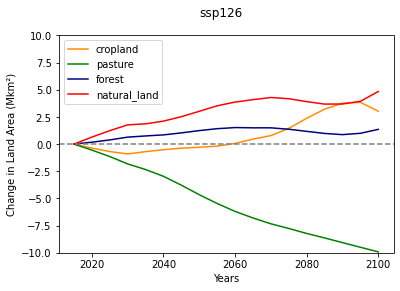

In [75]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Get the time values
time = da_landuse['time'].values
years = np.arange(2015, 2015 + len(time))


# Calculate the area per grid cell (km²)
lat_rad = np.deg2rad(da_landuse['lat'])
lon_rad = np.deg2rad(da_landuse['lon'])
radius_earth_km = 6371  # Earth's radius in kilometers

grid_cell_area_km2 = (
    2 * np.pi * (radius_earth_km ** 2) *
    (np.cos(lat_rad) * 0.25 * np.pi / 180) *  # Latitude cell size in radians
    (0.25 * np.pi / 180)  # Longitude cell size in radians
)


# Initialize the modified land use dataset
modified_landuse = da_landuse.copy()

# Loop over the data variables and convert the values to Mkm²
for variable in da_landuse.data_vars:
    modified_landuse[variable] = da_landuse[variable] * grid_cell_area_km2 / 1e6  # Convert to Mkm²

# Calculate the sum of values for each variable
sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable
#difference = sum_over_values - sum_over_values.isel(time=0)

# Create a new dataset for sum over categories
sum_over_categories = xr.Dataset()

# Sum the differences for cropland category
sum_over_categories['cropland'] = sum_over_values['c3ann'] + sum_over_values['c3per'] + sum_over_values['c4ann'] + sum_over_values['c4per'] + sum_over_values['c3nfx']

# Sum the differences for pasture category
sum_over_categories['pasture'] = sum_over_values['pastr'] + sum_over_values['range']

# Sum the differences for forest category
sum_over_categories['forest'] = sum_over_values['primf'] + sum_over_values['secdf']

# Sum the differences for natural_land category
sum_over_categories['natural_land'] = sum_over_values['primn'] + sum_over_values['secdn']

# Calculate the difference to Year 0 for each category
difference = sum_over_categories - sum_over_categories.isel(time=0)

category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
}


# Create a figure and axes
fig, ax = plt.subplots()

# Loop over the categories
for category in category_mapping:
    # Get the difference values for the current category
    values = difference[category].values

    # Plot the difference values for the current category with the corresponding color
    ax.plot(years, values, label=category, color=category_colors[category])

# Add a horizontal line at y=0.0
ax.axhline(y=0.0, color='grey', linestyle='--')

# Set the x-axis label and ticks
ax.set_xlabel('Years')

# Set the y-axis label
ax.set_ylabel('Change in Land Area (Mkm²)')

# Set the y-axis limits
ax.set_ylim(-10, 10)

# Add a legend
ax.legend()
plt.suptitle("ssp126")

# Display the plot
plt.show()


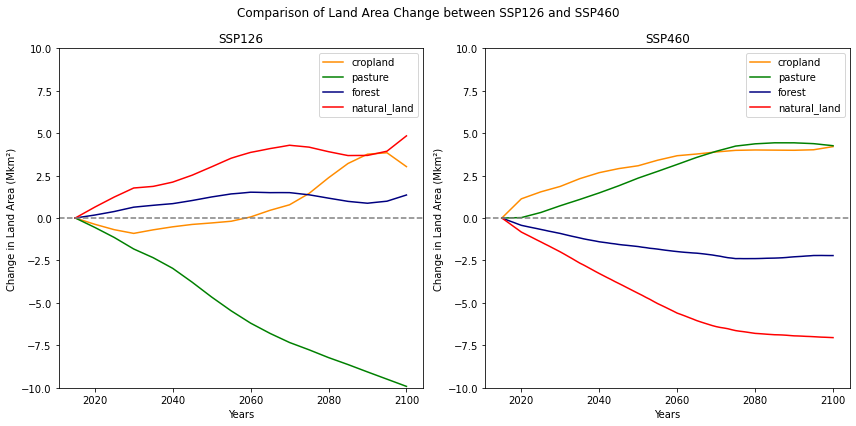

In [76]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the land use datasets for SSP126 and SSP460
ncfname_ssp126 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc"
ncfname_ssp460 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460.nc"
da_landuse_ssp126 = xr.open_dataset(ncfname_ssp126, decode_times=False)
da_landuse_ssp460 = xr.open_dataset(ncfname_ssp460, decode_times=False)

# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Get the time values
time_ssp126 = da_landuse_ssp126['time'].values
time_ssp460 = da_landuse_ssp460['time'].values
years_ssp126 = np.arange(2015, 2015 + len(time_ssp126))
years_ssp460 = np.arange(2015, 2015 + len(time_ssp460))

# Calculate the area per grid cell (km²)
lat_rad = np.deg2rad(da_landuse_ssp126['lat'])
lon_rad = np.deg2rad(da_landuse_ssp126['lon'])
radius_earth_km = 6371  # Earth's radius in kilometers

grid_cell_area_km2 = (
    2 * np.pi * (radius_earth_km ** 2) *
    (np.cos(lat_rad) * 0.25 * np.pi / 180) *  # Latitude cell size in radians
    (0.25 * np.pi / 180)  # Longitude cell size in radians
)


# Initialize the modified land use datasets
modified_landuse_ssp126 = da_landuse_ssp126.copy()
modified_landuse_ssp460 = da_landuse_ssp460.copy()

# Loop over the data variables and convert the values to Mkm² for SSP126
for variable in da_landuse_ssp126.data_vars:
    modified_landuse_ssp126[variable] = da_landuse_ssp126[variable] * grid_cell_area_km2 / 1e6  # Convert to Mkm²

# Loop over the data variables and convert the values to Mkm² for SSP460
for variable in da_landuse_ssp460.data_vars:
    modified_landuse_ssp460[variable] = da_landuse_ssp460[variable] * grid_cell_area_km2 / 1e6  # Convert to Mkm²

# Calculate the sum of values for each variable for SSP126
sum_over_values_ssp126 = modified_landuse_ssp126.sum(dim=[dim for dim in modified_landuse_ssp126.dims if dim != 'time'])

# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable for SSP126
difference_ssp126 = sum_over_values_ssp126 - sum_over_values_ssp126.isel(time=0)

# Create a new dataset for sum over categories for SSP126
sum_over_categories_ssp126 = xr.Dataset()

# Sum the differences for cropland category for SSP126
sum_over_categories_ssp126['cropland'] = sum_over_values_ssp126['c3ann'] + sum_over_values_ssp126['c3per'] + sum_over_values_ssp126['c4ann'] + sum_over_values_ssp126['c4per'] + sum_over_values_ssp126['c3nfx']

# Sum the differences for pasture category for SSP126
sum_over_categories_ssp126['pasture'] = sum_over_values_ssp126['pastr'] + sum_over_values_ssp126['range']

# Sum the differences for forest category for SSP126
sum_over_categories_ssp126['forest'] = sum_over_values_ssp126['primf'] + sum_over_values_ssp126['secdf']

# Sum the differences for natural_land category for SSP126
sum_over_categories_ssp126['natural_land'] = sum_over_values_ssp126['primn'] + sum_over_values_ssp126['secdn']

# Calculate the difference to Year 0 for each category for SSP126
difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_ssp126.isel(time=0)


# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Create a new dataset for sum over categories for SSP460
sum_over_categories_ssp460 = xr.Dataset()

# Sum the differences for cropland category for SSP460
sum_over_categories_ssp460['cropland'] = sum_over_values_ssp460['c3ann'] + sum_over_values_ssp460['c3per'] + sum_over_values_ssp460['c4ann'] + sum_over_values_ssp460['c4per'] + sum_over_values_ssp460['c3nfx']

# Sum the differences for pasture category for SSP460
sum_over_categories_ssp460['pasture'] = sum_over_values_ssp460['pastr'] + sum_over_values_ssp460['range']

# Sum the differences for forest category for SSP460
sum_over_categories_ssp460['forest'] = sum_over_values_ssp460['primf'] + sum_over_values_ssp460['secdf']

# Sum the differences for natural_land category for SSP460
sum_over_categories_ssp460['natural_land'] = sum_over_values_ssp460['primn'] + sum_over_values_ssp460['secdn']

# Calculate the difference to Year 0 for each category for SSP460
difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_ssp460.isel(time=0)


# Set the category colors
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
}


# Create a figure and axes for SSP126
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot SSP126 data
for category in category_mapping:
    values_ssp126 = difference_ssp126[category].values
    ax1.plot(years_ssp126, values_ssp126, label=category, color=category_colors[category])

ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.set_xlabel('Years')
ax1.set_ylabel('Change in Land Area (Mkm²)')
ax1.set_ylim(-10, 10)
ax1.legend()
ax1.set_title("SSP126")


# Plot SSP460 data
for category in category_mapping:
    values_ssp460 = difference_ssp460[category].values
    ax2.plot(years_ssp460, values_ssp460, label=category, color=category_colors[category])

ax2.axhline(y=0.0, color='grey', linestyle='--')
ax2.set_xlabel('Years')
ax2.set_ylabel('Change in Land Area (Mkm²)')
ax2.set_ylim(-10, 10)
ax2.legend()
ax2.set_title("SSP460")


# Add a suptitle
fig.suptitle("Comparison of Land Area Change between SSP126 and SSP460")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()



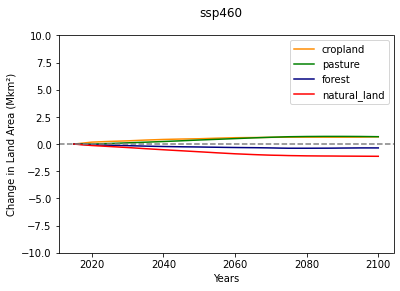

In [13]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp460" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

# Get the time values
time = da_landuse['time'].values
years = np.arange(2015, 2015 + len(time))


# Calculate the area per grid cell (Mkm²)
grid_cell_area_km2 = (111.32 * 0.25) * (111.32 * 0.25) * np.cos(np.deg2rad(da_landuse['lat']))

# Initialize the modified land use dataset
modified_landuse = da_landuse.copy()

# Loop over the data variables and convert the values to Mkm²
for variable in da_landuse.data_vars:
    modified_landuse[variable] = da_landuse[variable] * grid_cell_area_km2 / 1e6  # Convert to Mkm²

# Calculate the sum of values for each variable
sum_over_values = modified_landuse.sum(dim=[dim for dim in modified_landuse.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable
difference = sum_over_values - sum_over_values.isel(time=0)

# Create a new dataset for sum over categories
sum_over_categories = xr.Dataset()

# Sum the differences for cropland category
sum_over_categories['cropland'] = difference['c3ann'] + difference['c3per'] + difference['c4ann'] + difference['c4per'] + difference['c3nfx']

# Sum the differences for pasture category
sum_over_categories['pasture'] = difference['pastr'] + difference['range']

# Sum the differences for forest category
sum_over_categories['forest'] = difference['primf'] + difference['secdf']

# Sum the differences for natural_land category
sum_over_categories['natural_land'] = difference['primn'] + difference['secdn']

# Calculate the difference to Year 0 for each category
difference = sum_over_categories - sum_over_categories.isel(time=0)

# Define the colors for each category
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forest': '#000080',
    'natural_land': 'red'
}


# Create a figure and axes
fig, ax = plt.subplots()

# Loop over the categories
for category in category_mapping:
    # Get the difference values for the current category
    values = difference[category].values

    # Plot the difference values for the current category with the corresponding color
    ax.plot(years, values, label=category, color=category_colors[category])

# Add a horizontal line at y=0.0
ax.axhline(y=0.0, color='grey', linestyle='--')

# Set the x-axis label and ticks
ax.set_xlabel('Years')

# Set the y-axis label
ax.set_ylabel('Change in Land Area (Mkm²)')

# Set the y-axis limits
ax.set_ylim(-10, 10)

# Add a legend
ax.legend()
plt.suptitle("ssp460")

# Display the plot
plt.show()


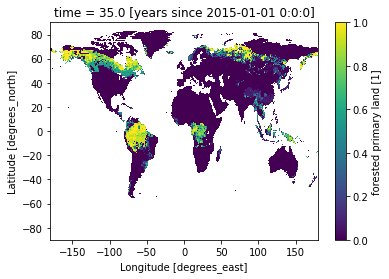

In [89]:
 da_landuse['primf'].sel(time=year).plot()

In [105]:
da_landuse

<xarray.Dataset>
Dimensions:    (time: 86, lon: 720, lat: 360, bounds: 2)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 81.0 82.0 83.0 84.0 85.0
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bounds
Data variables: (12/15)
    c3ann      (time, lat, lon) float32 ...
    c3nfx      (time, lat, lon) float32 ...
    c3per      (time, lat, lon) float32 ...
    c4ann      (time, lat, lon) float32 ...
    c4per      (time, lat, lon) float32 ...
    pastr      (time, lat, lon) float32 ...
    ...         ...
    secdf      (time, lat, lon) float32 ...
    secdn      (time, lat, lon) float32 ...
    secma      (time, lat, lon) float32 ...
    secmb      (time, lat, lon) float32 ...
    time_bnds  (time, bounds) int32 ...
    urban      (time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.6
    source:                  LUH2 v2.1f: Land-Use Harmonization Data Set
    institution:             University of Maryland (UofMD), College Park, MD...
    host:                    UMD College Park
    comment:                 LUH2
    ...                      ...
    source_id:               UofMD-landState-IMAGE-ssp126-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/329081ac-5a16-4170-8654-bf3bfc9beca2
    history:                 Sun Mar 05 15:20:57 2023: cdo remapbil,gfdl-esm4...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [179]:
da_landuse


<xarray.Dataset>
Dimensions:    (time: 86, lon: 720, lat: 360, bounds: 2)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 81.0 82.0 83.0 84.0 85.0
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bounds
Data variables: (12/15)
    c3ann      (time, lat, lon) float32 ...
    c3nfx      (time, lat, lon) float32 ...
    c3per      (time, lat, lon) float32 ...
    c4ann      (time, lat, lon) float32 ...
    c4per      (time, lat, lon) float32 ...
    pastr      (time, lat, lon) float32 ...
    ...         ...
    secdf      (time, lat, lon) float32 ...
    secdn      (time, lat, lon) float32 ...
    secma      (time, lat, lon) float32 ...
    secmb      (time, lat, lon) float32 ...
    time_bnds  (time, bounds) int32 ...
    urban      (time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.6
    source:                  LUH2 v2.1f: Land-Use Harmonization Data Set
    institution:             University of Maryland (UofMD), College Park, MD...
    host:                    UMD College Park
    comment:                 LUH2
    ...                      ...
    source_id:               UofMD-landState-IMAGE-ssp126-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/329081ac-5a16-4170-8654-bf3bfc9beca2
    history:                 Sun Mar 05 15:20:57 2023: cdo remapbil,gfdl-esm4...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

/scratch/local/54558292/ipykernel_101037/732919880.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


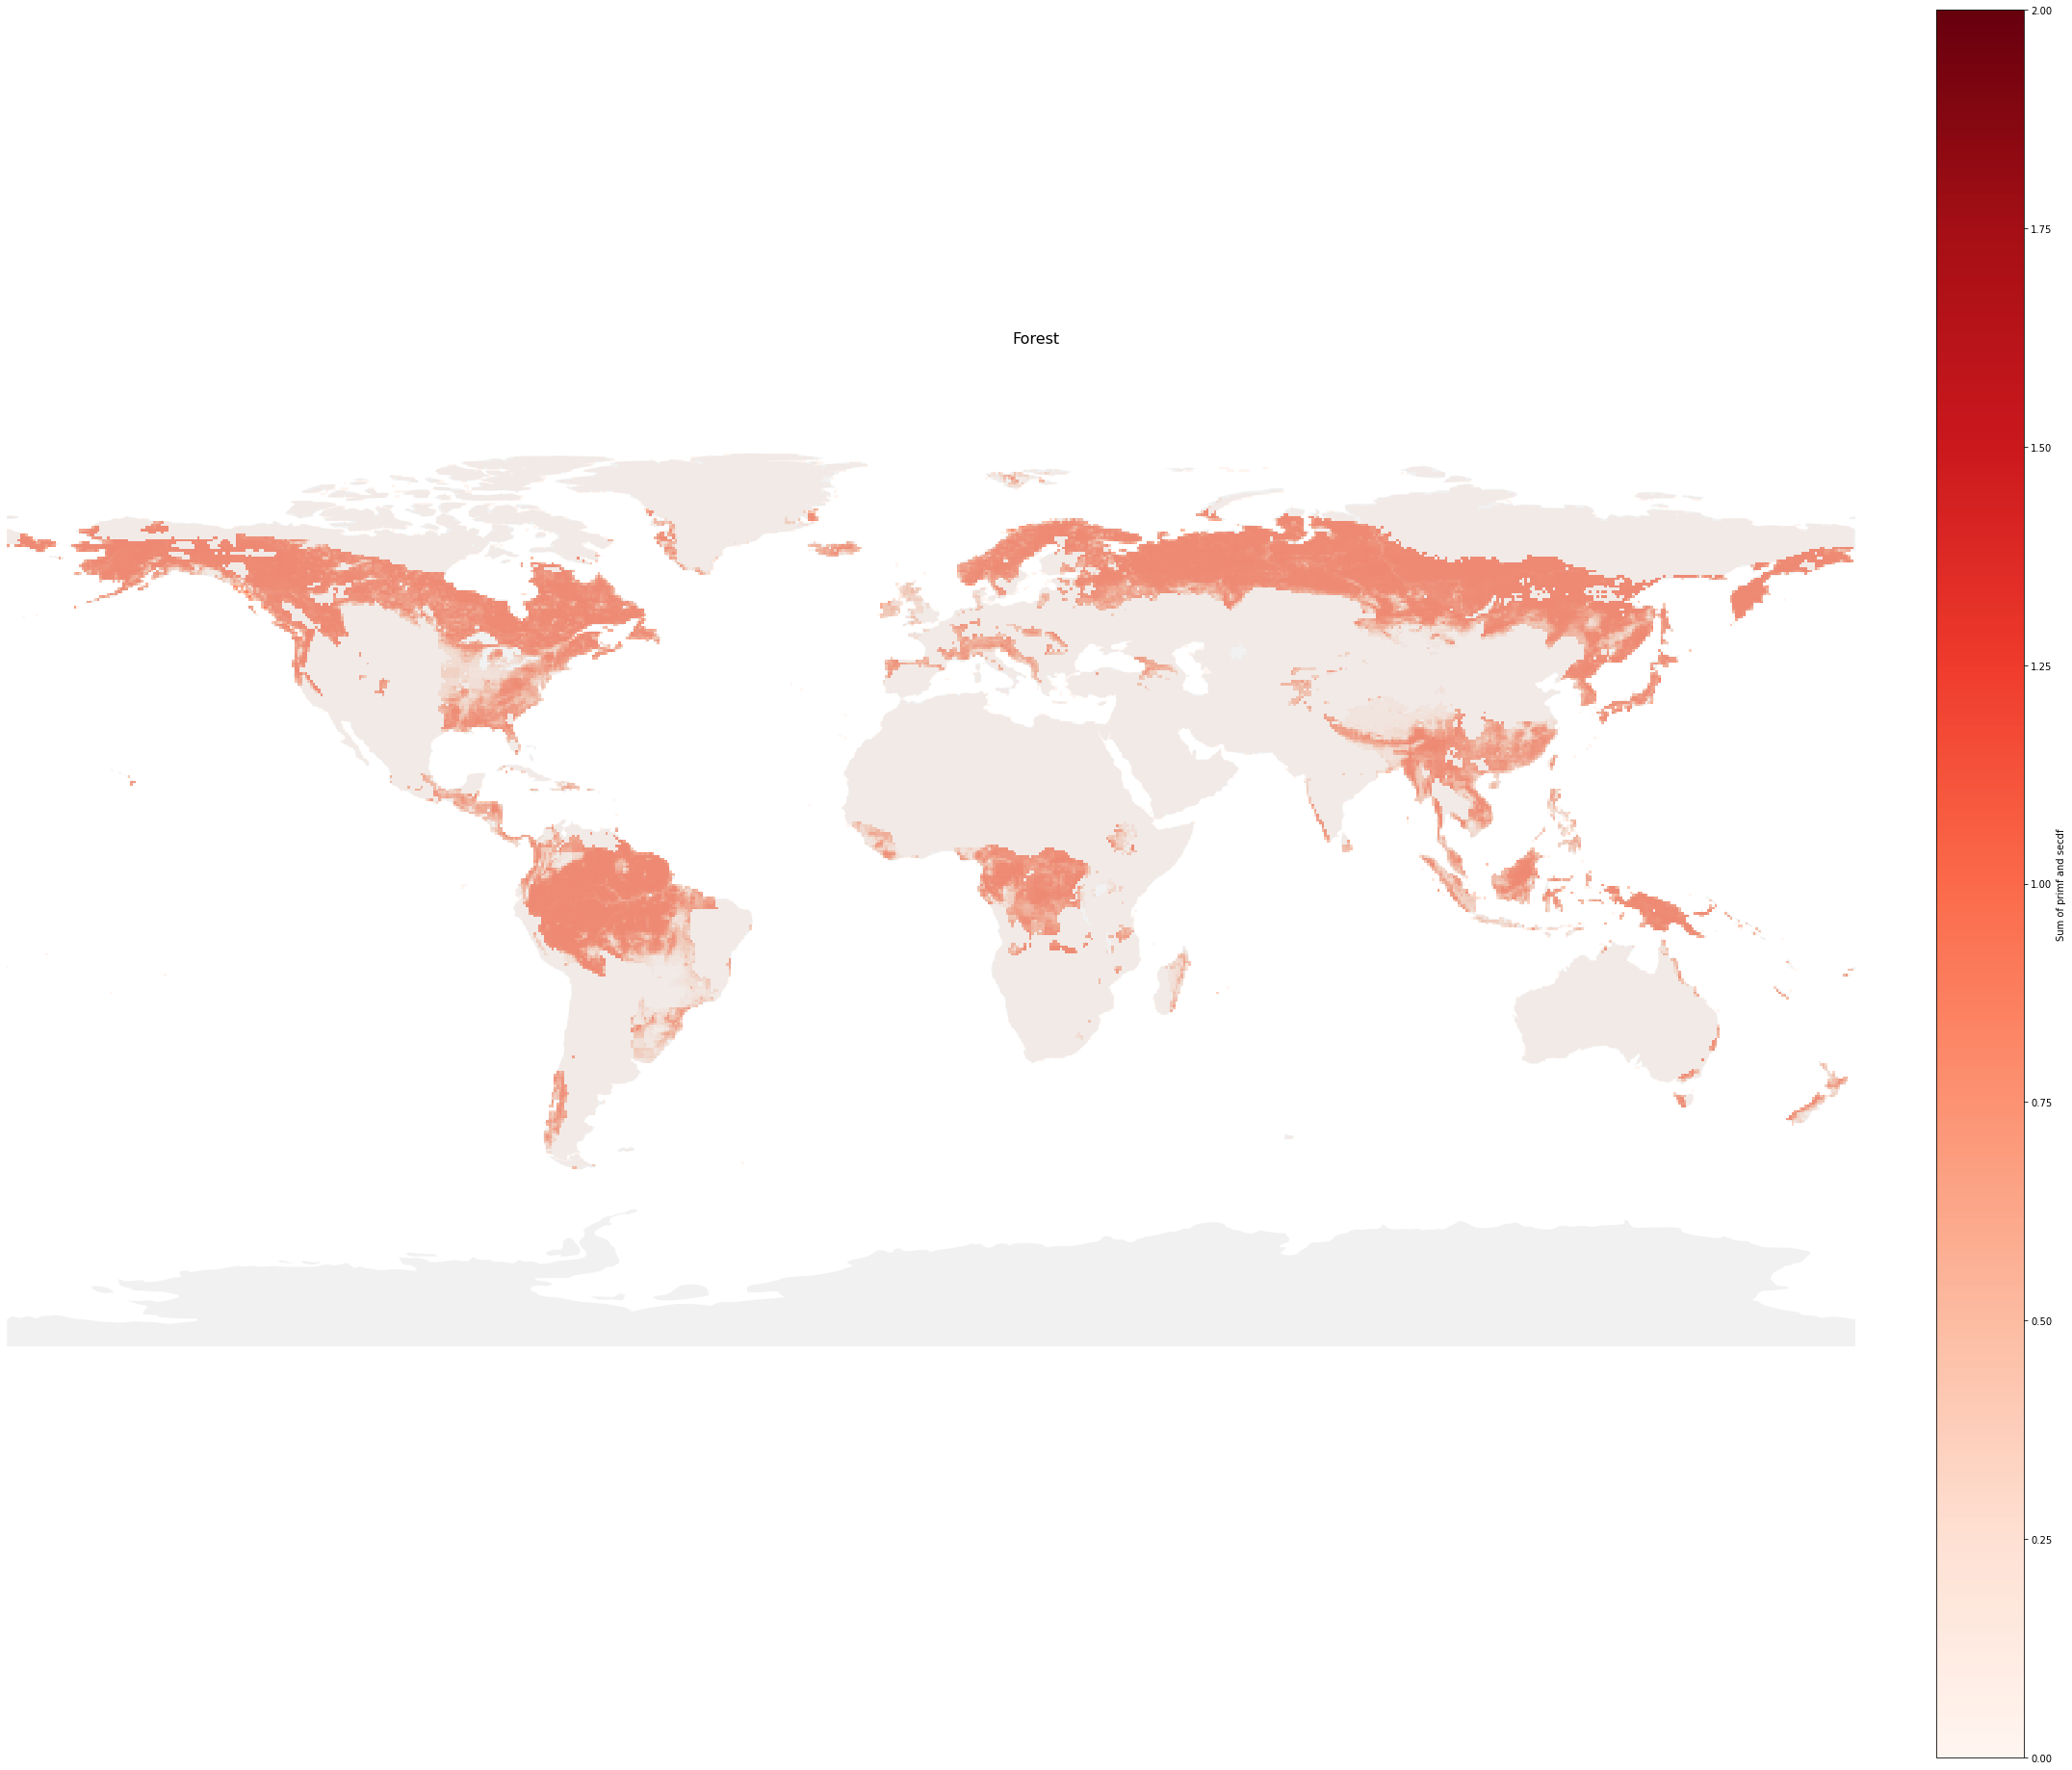

In [36]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

# Calculate the sum of primf and secdf
landuse_sum = da_landuse_2050['primf'] + da_landuse_2050['secdf']

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the sum of primf and secdf
cmap = get_cmap('Reds')
im = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], landuse_sum.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=2
)

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Sum of primf and secdf')

plt.suptitle("Forest",y=0.8,size=16)
plt.show()


/scratch/local/54558292/ipykernel_101037/2767458183.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


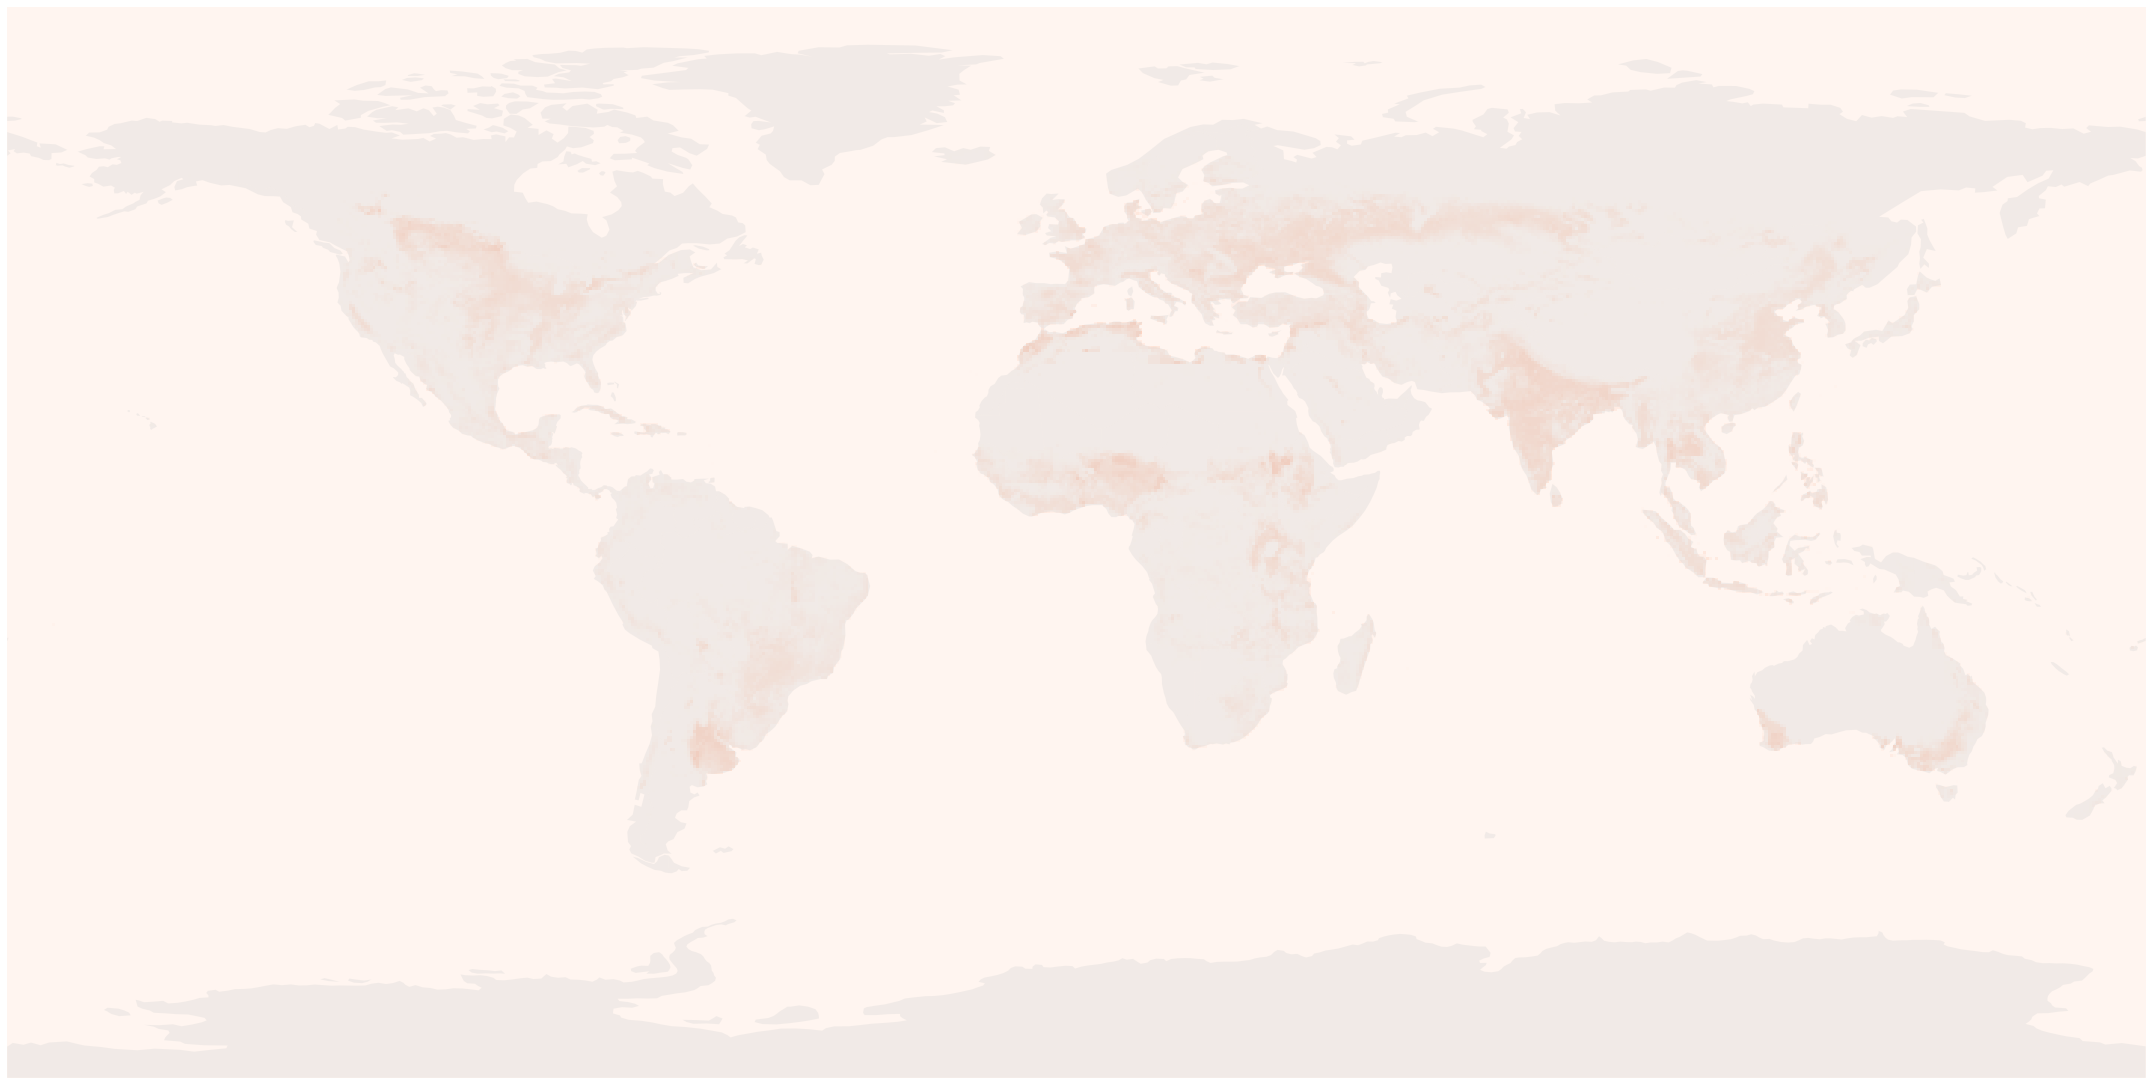

In [59]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

# Create a new variable for the sum of c3ann, c3nfx, c3per, c4ann, and c4per
sum_variable = da_landuse_2050['c3ann'] + da_landuse_2050['c3nfx'] + da_landuse_2050['c3per'] + da_landuse_2050['c4ann'] + da_landuse_2050['c4per']
sum_variable =sum_variable.where(sum_variable > 0, 0)

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = get_cmap('Reds')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the sum_variable
im = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, sum_variable.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=5  # Adjust vmin and vmax as needed
)

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')



plt.show()


/scratch/local/54558292/ipykernel_101037/3949931705.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


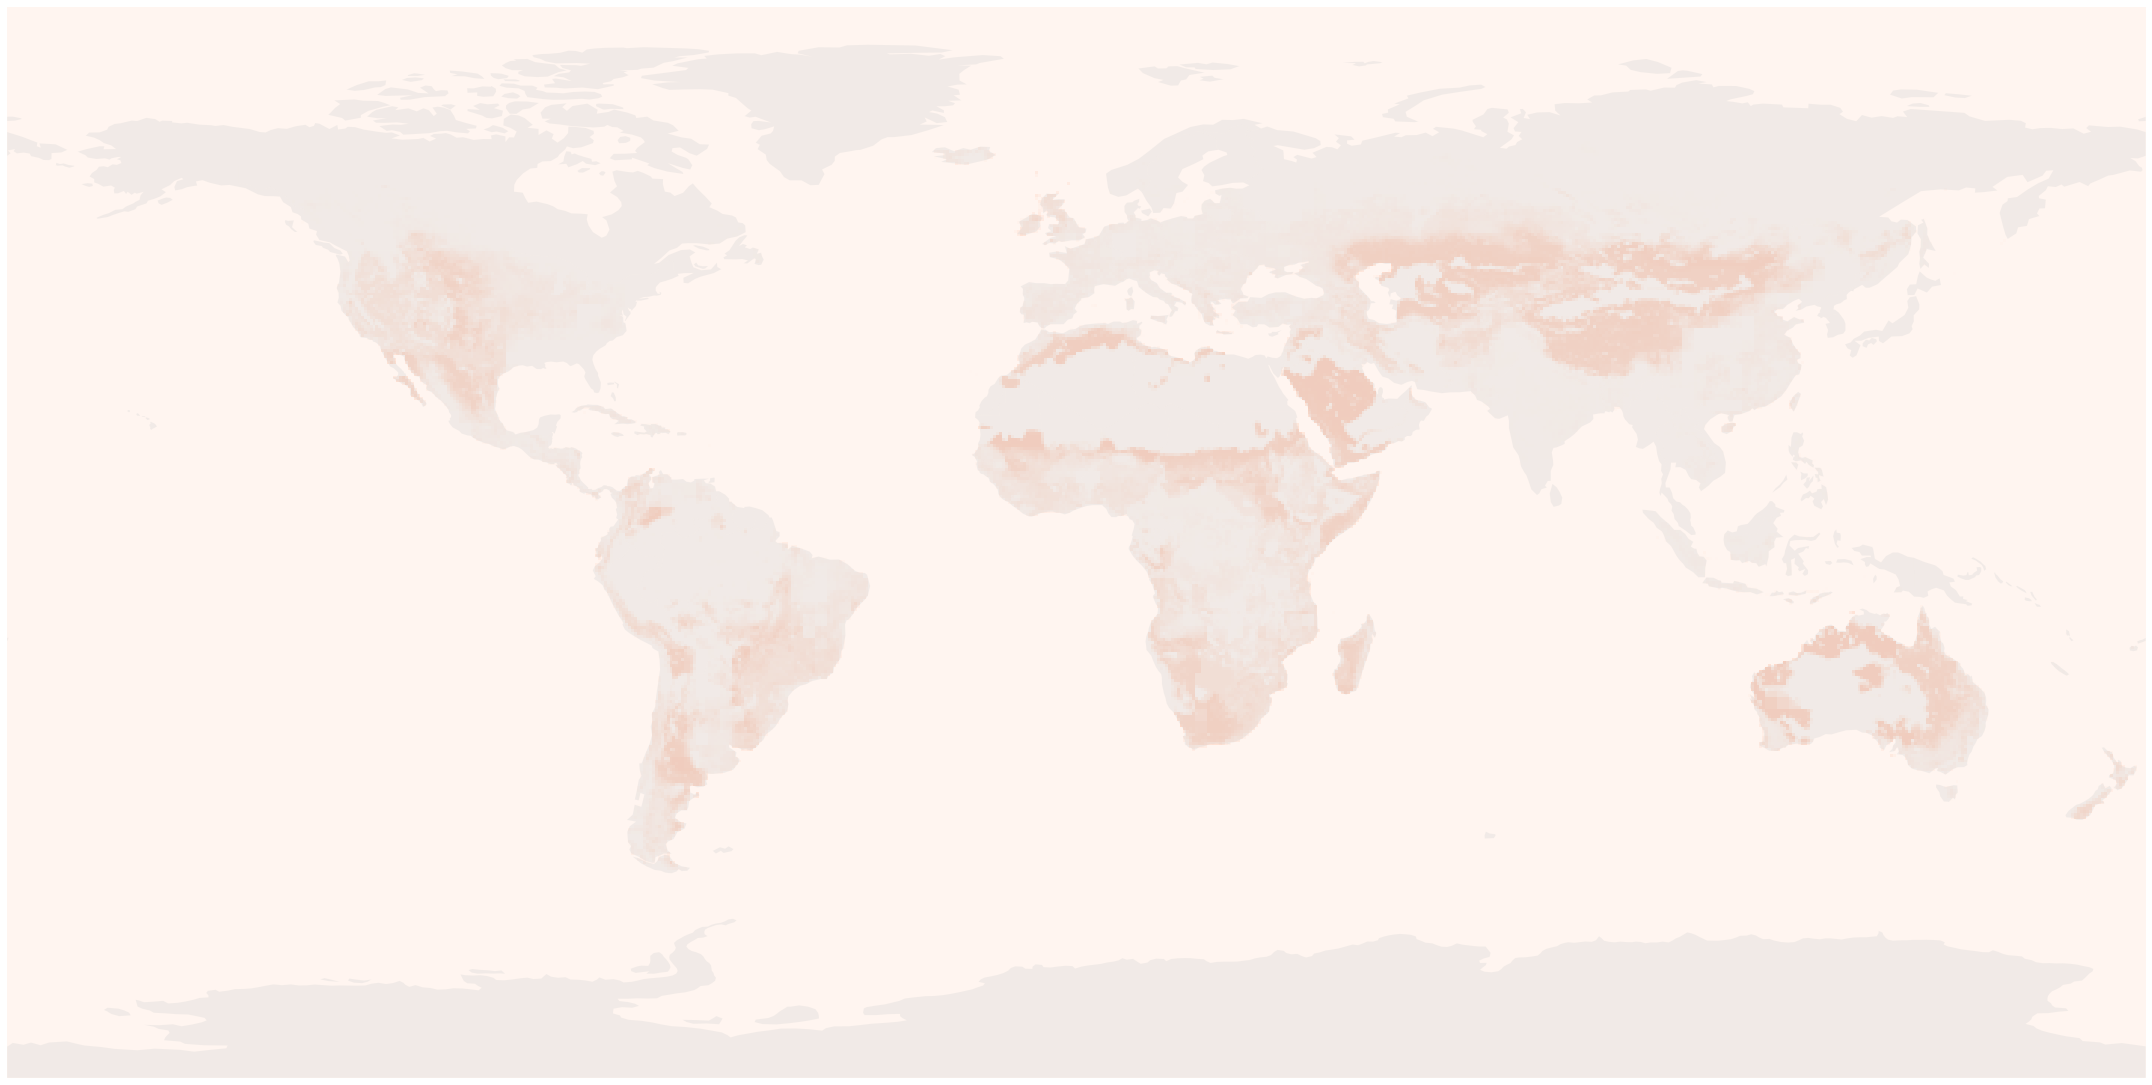

In [60]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

# Create a new variable for the sum of c3ann, c3nfx, c3per, c4ann, and c4per
sum_variable = da_landuse_2050['pastr'] + da_landuse_2050['range']
sum_variable =sum_variable.where(sum_variable > 0, 0)

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = get_cmap('Reds')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the sum_variable
im = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, sum_variable.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=5  # Adjust vmin and vmax as needed
)

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')



plt.show()


/scratch/local/54558292/ipykernel_101037/3019606522.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


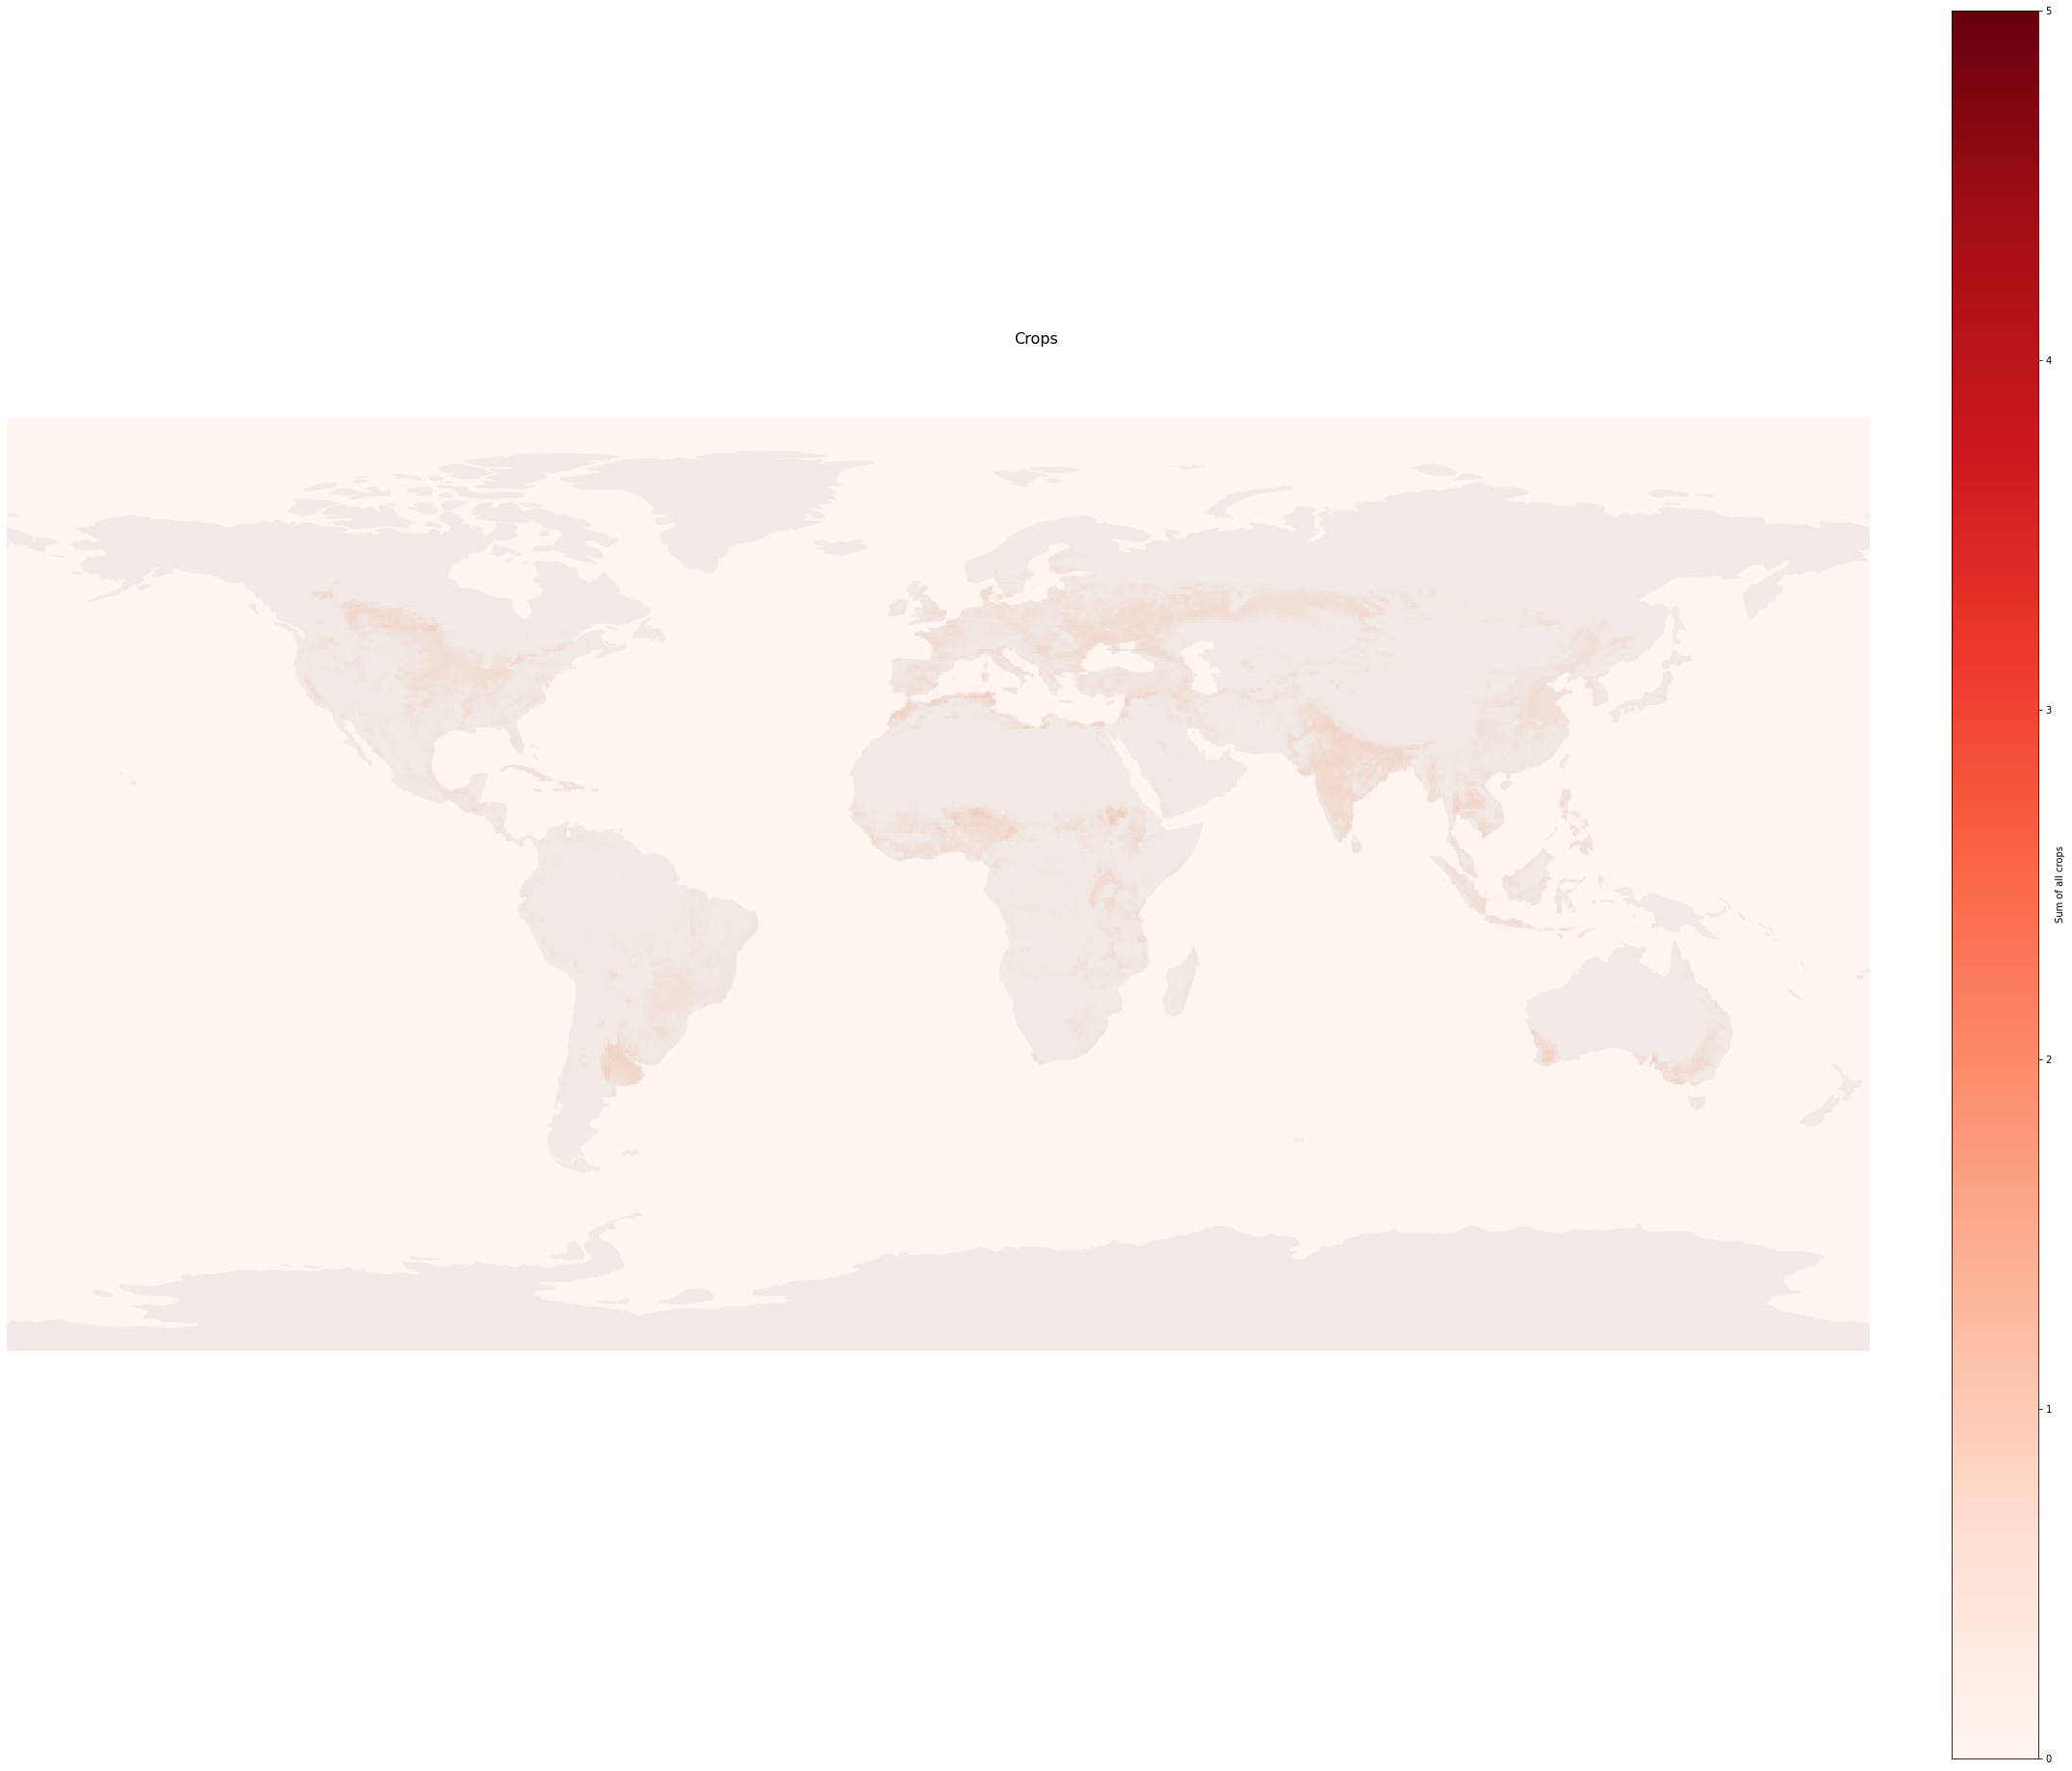

In [50]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, Normalize
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

# Create binary variables
c3ann_binary = da_landuse_2050['c3ann'].where(da_landuse_2050['c3ann'] > 0, 0)
c3nfx_binary = da_landuse_2050['c3nfx'].where(da_landuse_2050['c3nfx'] > 0, 0)
c3per_binary = da_landuse_2050['c3per'].where(da_landuse_2050['c3per'] > 0, 0)
c4ann_binary = da_landuse_2050['c4ann'].where(da_landuse_2050['c4ann'] > 0, 0)
c4per_binary = da_landuse_2050['c4per'].where(da_landuse_2050['c4per'] > 0, 0)

# Create the sum variable
sum_variable = c3ann_binary + c3nfx_binary + c3per_binary + c4ann_binary + c4per_binary

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = get_cmap('Reds')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the sum_variable
im = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, sum_variable.values,
    transform=ccrs.PlateCarree(), cmap=cmap, norm=Normalize(vmin=0, vmax=5)
)

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Sum of all crops')

plt.suptitle("Crops", y=0.8, size=16)

plt.show()


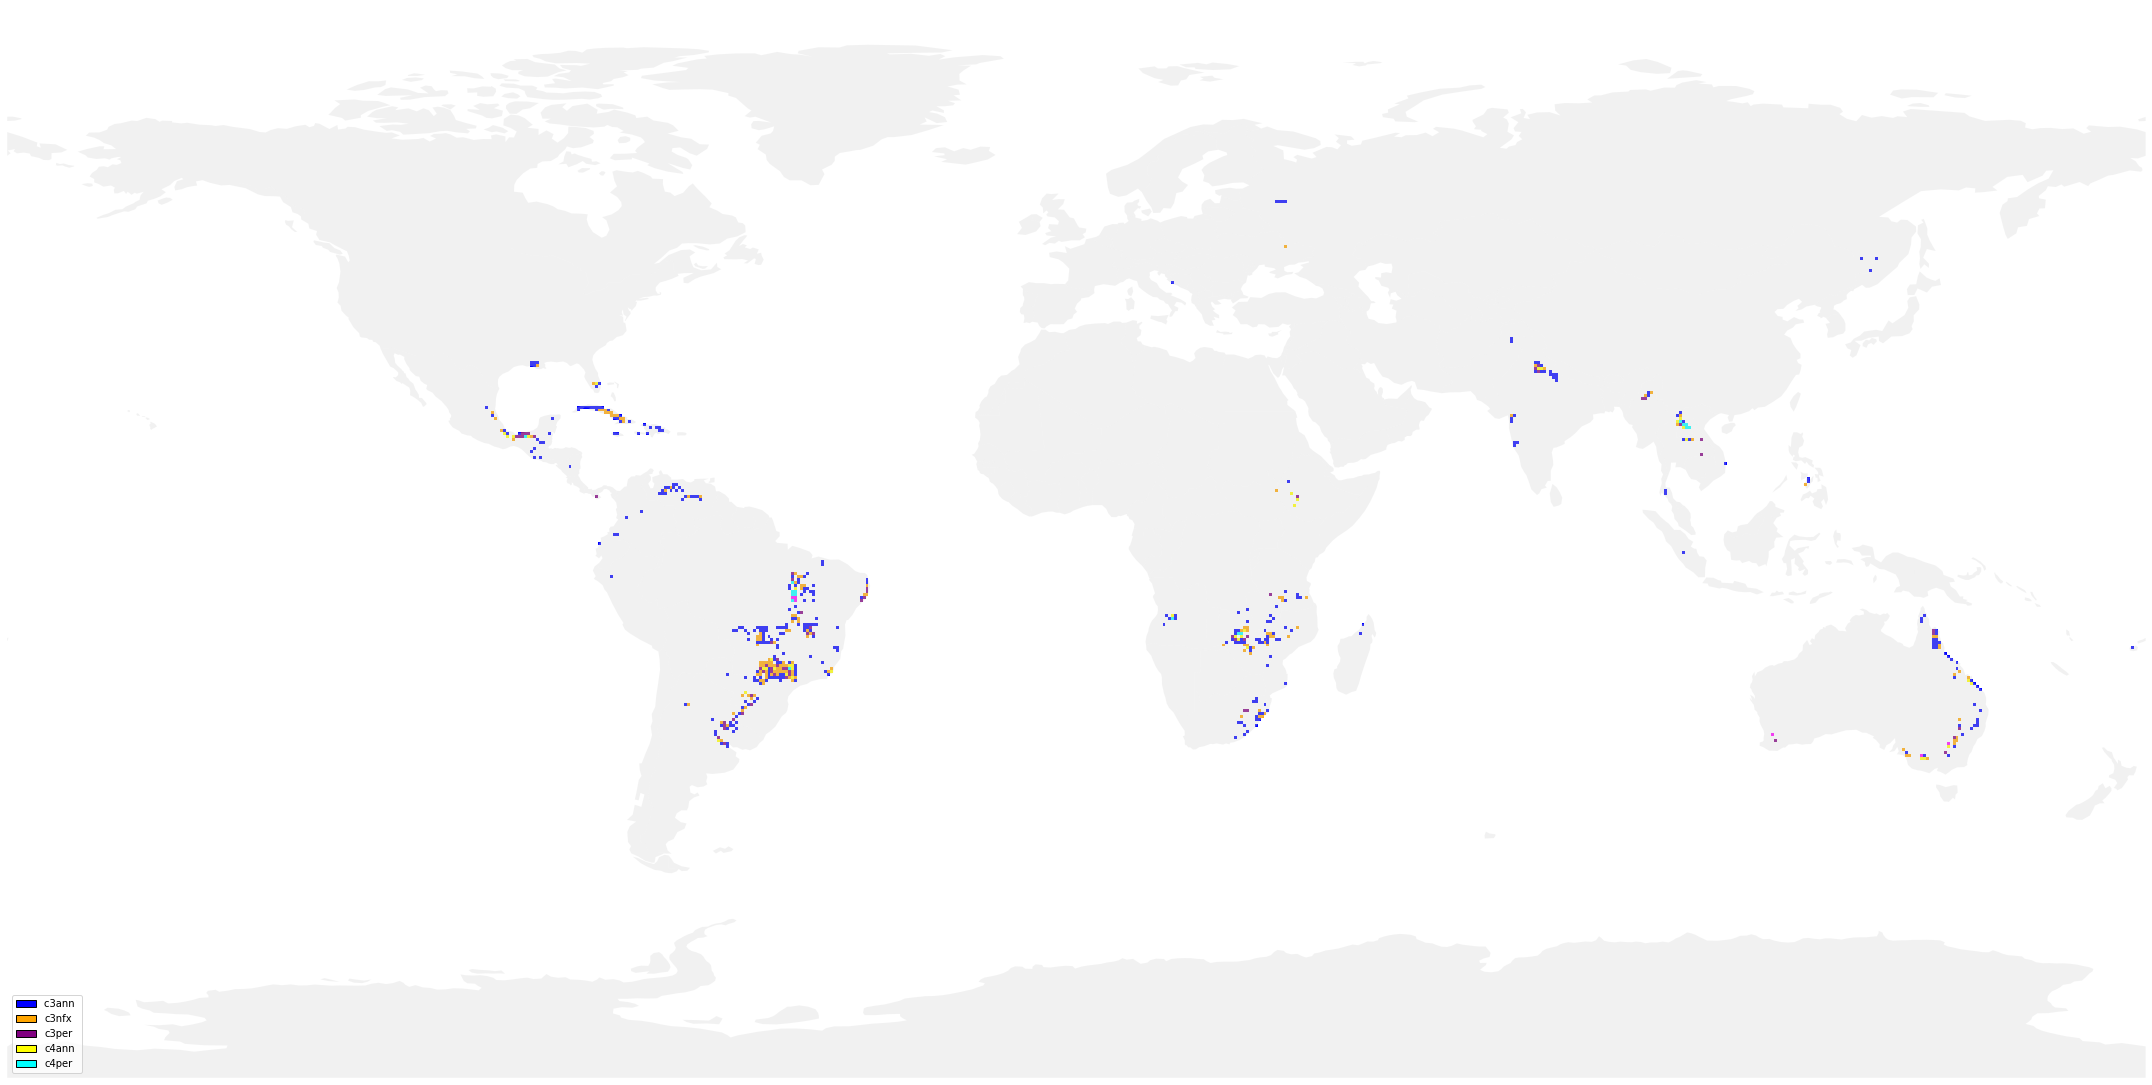

In [20]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = ListedColormap(['white','blue', 'orange', 'purple', 'yellow', 'cyan',
                       'magenta', 'brown', 'lime', 'pink', 'teal', 'olive', 'gray'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Subset and plot each variable individually

# Subset and plot additional variables (add more as needed)
c3ann_masked = da_landuse_2050['c3ann']
im3 = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, c3ann_masked.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

# Subset and plot additional variables
c3nfx_masked = da_landuse_2050['c3nfx']
im4 = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, c3nfx_masked.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c3per_masked = da_landuse_2050['c3per']
im5 = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, c3per_masked.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4ann_masked = da_landuse_2050['c4ann']
im6 = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, c4ann_masked.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4per_masked = da_landuse_2050['c4per']
im7 = ax1.pcolormesh(
    da_landuse_2050['lon'].values, da_landuse_2050['lat'].values, c4per_masked.values,
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)


# Continue with the remaining variables...

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')

# Add a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', edgecolor='black', label='c3ann '),
    # Add more legend elements for each variable
    plt.Rectangle((0, 0), 1, 1, facecolor='orange', edgecolor='black', label='c3nfx'),
    plt.Rectangle((0, 0), 1, 1, facecolor='purple', edgecolor='black', label='c3per' ),
    plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', label='c4ann'),
    plt.Rectangle((0, 0), 1, 1, facecolor='cyan', edgecolor='black', label='c4per')

]

ax1.legend(handles=legend_elements, loc='lower left')

plt.show()



In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = ListedColormap(['white', 'green', 'red', 'blue', 'orange', 'purple', 'yellow', 'cyan',
                       'magenta', 'brown', 'lime', 'pink', 'teal', 'olive', 'gray'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Subset and plot each variable individually
primf_masked = da_landuse_2050['primf'].where(da_landuse_2050['primf'] > 0, 0)
im1 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], primf_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

secdf_masked = da_landuse_2050['secdf'].where(da_landuse_2050['secdf'] > 0, 0)
im2 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdf_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

# Subset and plot additional variables (add more as needed)
c3ann_masked = da_landuse_2050['c3ann'].where(da_landuse_2050['c3ann'] > 0, 0)
im3 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3ann_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

# Subset and plot additional variables
c3nfx_masked = da_landuse_2050['c3nfx'].where(da_landuse_2050['c3nfx'] > 0, 0)
im4 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3nfx_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c3per_masked = da_landuse_2050['c3per'].where(da_landuse_2050['c3per'] > 0, 0)
im5 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3per_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4ann_masked = da_landuse_2050['c4ann'].where(da_landuse_2050['c4ann'] > 0, 0)
im6 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c4ann_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4per_masked = da_landuse_2050['c4per'].where(da_landuse_2050['c4per'] > 0, 0)
im7 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c4per_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

pastr_masked = da_landuse_2050['pastr'].where(da_landuse_2050['pastr'] > 0, 0)
im8 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], pastr_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

primn_masked = da_landuse_2050['primn'].where(da_landuse_2050['primn'] > 0, 0)
im9 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], primn_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

range_masked = da_landuse_2050['range'].where(da_landuse_2050['range'] > 0, 0)
im10 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], range_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)
secdm_masked = da_landuse_2050['secdm'].where(da_landuse_2050['secdm'] > 0, 0)
im11 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdm_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

secma_masked = da_landuse_2050['secma'].where(da_landuse_2050['secma'] > 0, 0)
im12 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdo_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)




urban_masked = da_landuse_2050['urban'].where(da_landuse_2050['urban'] > 0, 0)
im15 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], urban_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)


# Continue with the remaining variables...

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')

# Add a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', edgecolor='black', label='c3ann > 0'),
    # Add more legend elements for each variable
    plt.Rectangle((0, 0), 1, 1, facecolor='orange', edgecolor='black', label='c3nfx > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='purple', edgecolor='black', label='c3per > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', label='c4ann > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='cyan', edgecolor='black', label='c4per > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='magenta', edgecolor='black', label='pastr > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='brown', edgecolor='black', label='primn > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='lime', edgecolor='black', label='range > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='pink', edgecolor='black', label='secdn > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='teal', edgecolor='black', label='secma > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='olive', edgecolor='black', label='secmb > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black', label='urban > 0')
]

ax1.legend(handles=legend_elements, loc='lower left')

plt.show()



KeyError: 'secdm'

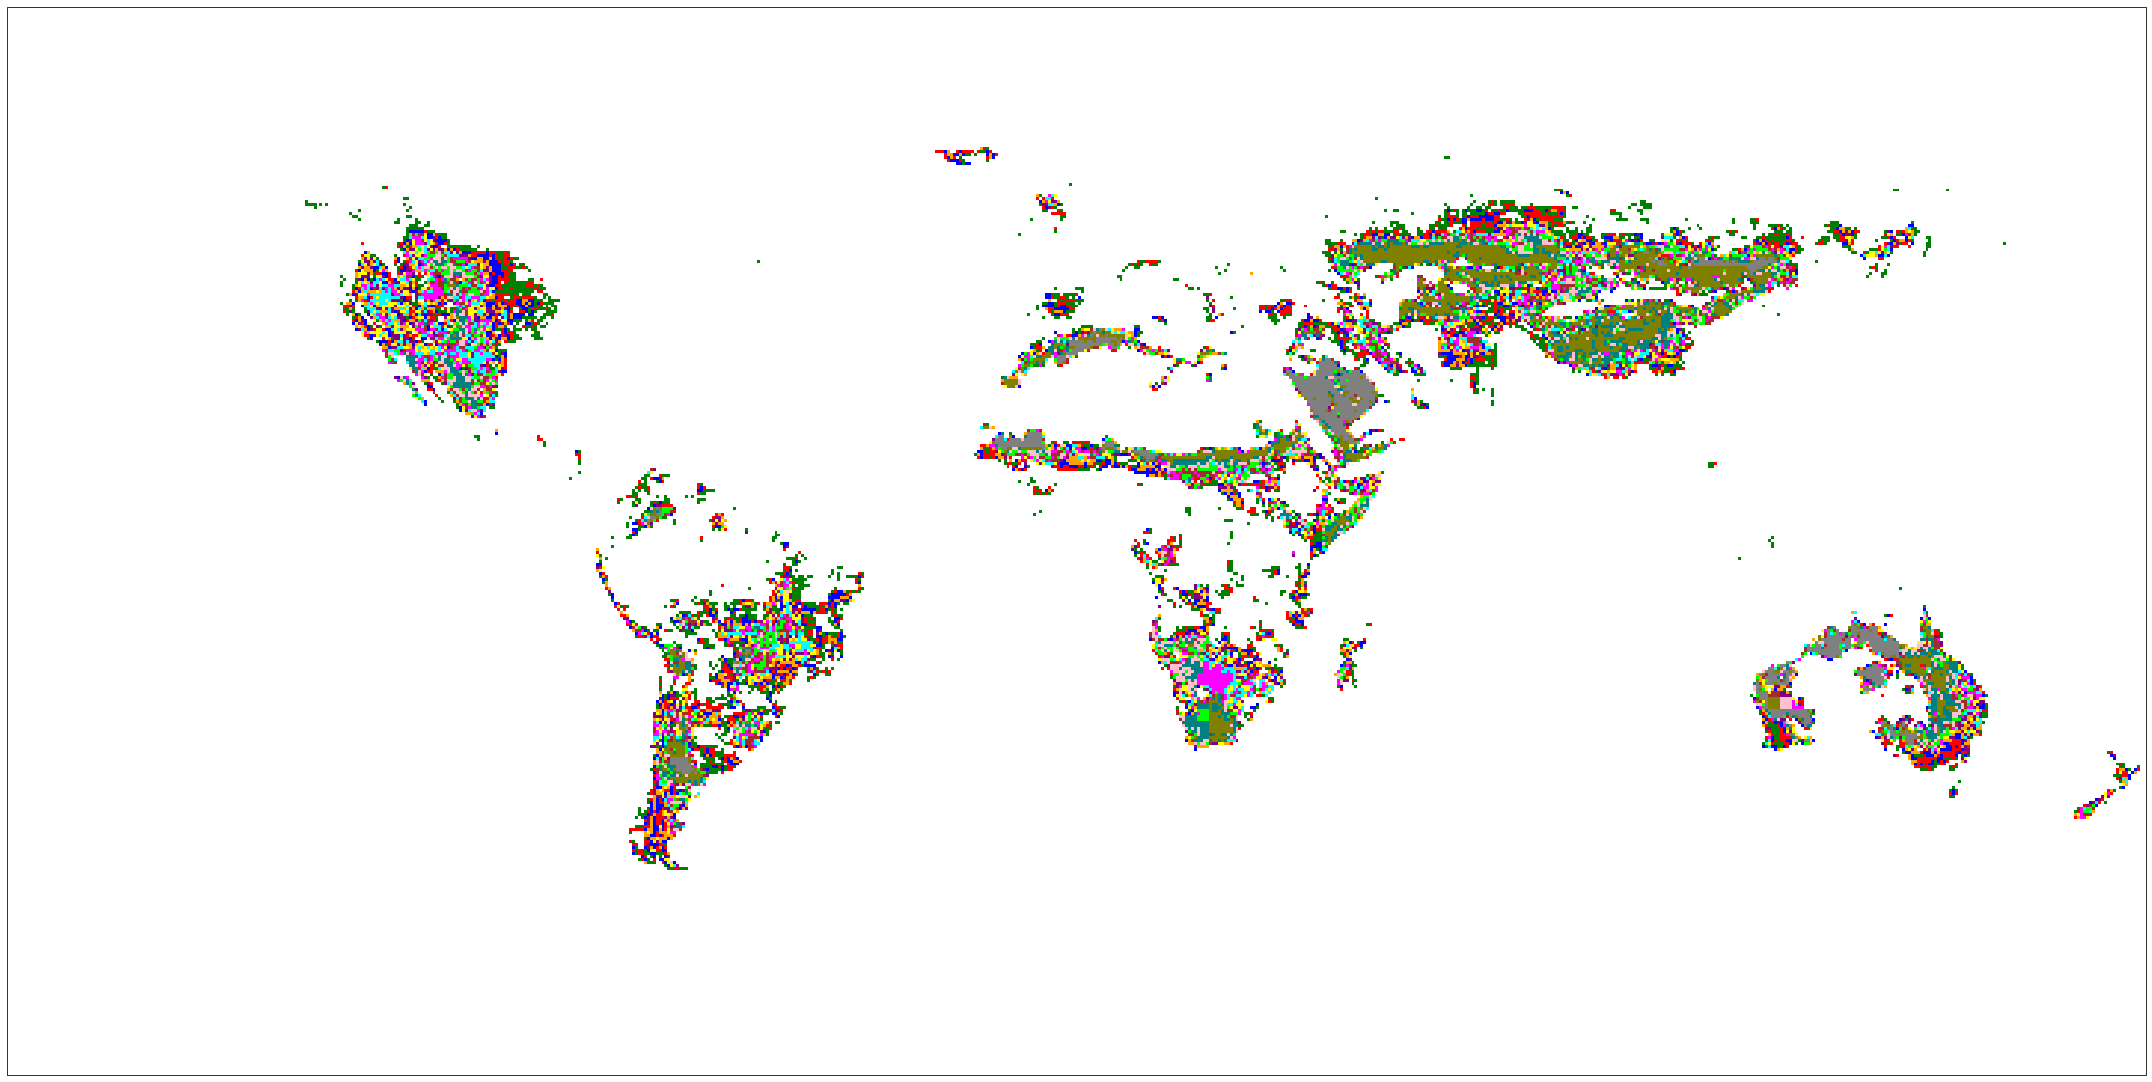

In [186]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

# Load the land use dataset
ncfname = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + "ssp126" + ".nc"
da_landuse = xr.open_dataset(ncfname, decode_times=False)

# Subset the dataset for time=35 (year 2050)
da_landuse_2050 = da_landuse.isel(time=35)

fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(30, 26),
    subplot_kw={'projection': ccrs.PlateCarree()},
    tight_layout=True
)

cmap = ListedColormap(['white', 'green', 'red', 'blue', 'orange', 'purple', 'yellow', 'cyan',
                       'magenta', 'brown', 'lime', 'pink', 'teal', 'olive', 'gray'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Subset and plot each variable individually
primf_masked = da_landuse_2050['primf'].where(da_landuse_2050['primf'] > 0, 0)
im1 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], primf_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

secdf_masked = da_landuse_2050['secdf'].where(da_landuse_2050['secdf'] > 0, 0)
im2 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdf_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

# Subset and plot additional variables (add more as needed)
c3ann_masked = da_landuse_2050['c3ann'].where(da_landuse_2050['c3ann'] > 0, 0)
im3 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3ann_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

# Subset and plot additional variables
c3nfx_masked = da_landuse_2050['c3nfx'].where(da_landuse_2050['c3nfx'] > 0, 0)
im4 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3nfx_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c3per_masked = da_landuse_2050['c3per'].where(da_landuse_2050['c3per'] > 0, 0)
im5 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c3per_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4ann_masked = da_landuse_2050['c4ann'].where(da_landuse_2050['c4ann'] > 0, 0)
im6 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c4ann_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

c4per_masked = da_landuse_2050['c4per'].where(da_landuse_2050['c4per'] > 0, 0)
im7 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], c4per_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

pastr_masked = da_landuse_2050['pastr'].where(da_landuse_2050['pastr'] > 0, 0)
im8 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], pastr_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

primn_masked = da_landuse_2050['primn'].where(da_landuse_2050['primn'] > 0, 0)
im9 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], primn_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

range_masked = da_landuse_2050['range'].where(da_landuse_2050['range'] > 0, 0)
im10 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], range_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)
secdm_masked = da_landuse_2050['secdm'].where(da_landuse_2050['secdm'] > 0, 0)
im11 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdm_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)

secma_masked = da_landuse_2050['secma'].where(da_landuse_2050['secma'] > 0, 0)
im12 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], secdo_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)




urban_masked = da_landuse_2050['urban'].where(da_landuse_2050['urban'] > 0, 0)
im15 = ax1.pcolormesh(
    da_landuse_2050['lon'].values[:-1], da_landuse_2050['lat'].values[:-1], urban_masked.values[:-1, :-1],
    transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1
)


# Continue with the remaining variables...

countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
ax1.axis('off')

# Add a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='green', edgecolor='black', label='primf > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', label='secdf > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', edgecolor='black', label='c3ann > 0'),
    # Add more legend elements for each variable
    plt.Rectangle((0, 0), 1, 1, facecolor='orange', edgecolor='black', label='c3nfx > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='purple', edgecolor='black', label='c3per > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', label='c4ann > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='cyan', edgecolor='black', label='c4per > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='magenta', edgecolor='black', label='pastr > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='brown', edgecolor='black', label='primn > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='lime', edgecolor='black', label='range > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='pink', edgecolor='black', label='secdn > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='teal', edgecolor='black', label='secma > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='olive', edgecolor='black', label='secmb > 0'),
    plt.Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black', label='urban > 0')
]

ax1.legend(handles=legend_elements, loc='lower left')

plt.show()

